![Add a relevant banner image here](path_to_image)

# Project Title

## Overview

Short project description. Your bottom line up front (BLUF) insights.

## Business Understanding

Text here

---

## Data Understanding

---

### Data Preview

In [83]:
import warnings
import pandas as pd

warnings.filterwarnings("ignore", category=FutureWarning)

In [84]:
# Helper Functions

SECTION_DIVIDER = "=" * 40
SUB_SECTION_DIVIDER = "-" * 40

def print_heading(title: str):
    """Print visually distinct section headers for notebook output."""
    print(f"\n{SECTION_DIVIDER}\n{title}\n{SECTION_DIVIDER}\n")

def print_sub_heading(title: str):
    """Print visually distinct sub section headers for notebook output."""
    print(f"\n{SUB_SECTION_DIVIDER}\n{title}\n{SUB_SECTION_DIVIDER}\n")

In [85]:
# Load the CSV file into a DataFrame
df = pd.read_csv("./Data/US_Accidents_March23.csv")

In [86]:
# Optional: preview the first few rows
print_heading("Original Data")

print_sub_heading("Head")
pd.set_option('display.max_columns', None)
display(df.head())
pd.reset_option('display.max_columns')

print_sub_heading("Info")
display(df.info())

print_sub_heading("Nulls")
display(df.isnull().sum())

print_sub_heading("Nulls %")
display((df.isnull().sum() / len(df)) * 100)

print_sub_heading("Description")
display(df.describe())

display(df['Sunrise_Sunset'].value_counts())
display(df['Civil_Twilight'].value_counts())
display(df['Nautical_Twilight'].value_counts())
display(df['Astronomical_Twilight'].value_counts())
display(df['Weather_Condition'].value_counts())


# ---------------------------------------------
# Categorical Imbalances and Dominant Categories
# ---------------------------------------------
print_sub_heading("Categorical Imbalances (Top Categories Overview)")

print(
    "Reviewing the top categorical values helps detect skew or missing diversity in the data — "
    "for instance, if most records come from a single city, timezone, or airport code, "
    "it might indicate reporting bias or localized data collection."
)

# Top 10 cities by record count
top_cities = df["City"].value_counts().head(10)
print("\nTop 10 Cities by Accident Count:")
display(top_cities)

# Top 10 counties
top_counties = df["County"].value_counts().head(10)
print("\nTop 10 Counties by Accident Count:")
display(top_counties)

# Top timezones
timezones = df["Timezone"].value_counts()
print("\nTimezone Distribution:")
display(timezones)

# Top 10 airport codes (can hint at weather reporting sites)
top_airports = df["Airport_Code"].value_counts().head(10)
print("\nTop 10 Airport Codes (Weather Sources):")
display(top_airports)

# Sanity check: Weather_Timestamp offsets (if available)
df["Weather_Timestamp"] = pd.to_datetime(df["Weather_Timestamp"], errors="coerce")
time_diff = (pd.to_datetime(df["Start_Time"], errors="coerce") - df["Weather_Timestamp"]).dt.total_seconds() / 3600
print("\nAverage difference between Start_Time and Weather_Timestamp (hours):")
print(time_diff.mean().round(2))




Original Data


----------------------------------------
Head
----------------------------------------



,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,I-70 E,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,Brice Rd,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,Accident on OH-32 State Route 32 Westbound at ...,State Route 32,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,Accident on I-75 Southbound at Exits 52 52B US...,I-75 S,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,Miamisburg Centerville Rd,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day



----------------------------------------
Info
----------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 11  Street                 object 
 12  City                   object 
 13  County                 object 
 14  State                  object 
 15  Zipcode                object 
 16  Country                object 
 17  Timezone               object 
 18  Airport_Code           object 
 19  Weather_Timestamp      object 
 20  T

None


----------------------------------------
Nulls
----------------------------------------



ID                             0
Source                         0
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                  3402762
End_Lng                  3402762
Distance(mi)                   0
Description                    5
Street                     10869
City                         253
County                         0
State                          0
Zipcode                     1915
Country                        0
Timezone                    7808
Airport_Code               22635
Weather_Timestamp         120228
Temperature(F)            163853
Wind_Chill(F)            1999019
Humidity(%)               174144
Pressure(in)              140679
Visibility(mi)            177098
Wind_Direction            175206
Wind_Speed(mph)           571233
Precipitation(in)        2203586
Weather_Condition         173459
Amenity                        0
Bump      


----------------------------------------
Nulls %
----------------------------------------



ID                        0.000000
Source                    0.000000
Severity                  0.000000
Start_Time                0.000000
End_Time                  0.000000
Start_Lat                 0.000000
Start_Lng                 0.000000
End_Lat                  44.029355
End_Lng                  44.029355
Distance(mi)              0.000000
Description               0.000065
Street                    0.140637
City                      0.003274
County                    0.000000
State                     0.000000
Zipcode                   0.024779
Country                   0.000000
Timezone                  0.101030
Airport_Code              0.292881
Weather_Timestamp         1.555666
Temperature(F)            2.120143
Wind_Chill(F)            25.865904
Humidity(%)               2.253301
Pressure(in)              1.820288
Visibility(mi)            2.291524
Wind_Direction            2.267043
Wind_Speed(mph)           7.391355
Precipitation(in)        28.512858
Weather_Condition   


----------------------------------------
Description
----------------------------------------



,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,7.728394e+06,7.728394e+06,7.728394e+06,4.325632e+06,4.325632e+06,7.728394e+06,7.564541e+06,5.729375e+06,7.554250e+06,7.587715e+06,7.551296e+06,7.157161e+06,5.524808e+06
mean,2.212384e+00,3.620119e+01,-9.470255e+01,3.626183e+01,-9.572557e+01,5.618423e-01,6.166329e+01,5.825105e+01,6.483104e+01,2.953899e+01,9.090376e+00,7.685490e+00,8.407210e-03
std,4.875313e-01,5.076079e+00,1.739176e+01,5.272905e+00,1.810793e+01,1.776811e+00,1.901365e+01,2.238983e+01,2.282097e+01,1.006190e+00,2.688316e+00,5.424983e+00,1.102246e-01
min,1.000000e+00,2.455480e+01,-1.246238e+02,2.456601e+01,-1.245457e+02,0.000000e+00,-8.900000e+01,-8.900000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,3.339963e+01,-1.172194e+02,3.346207e+01,-1.177543e+02,0.000000e+00,4.900000e+01,4.300000e+01,4.800000e+01,2.937000e+01,1.000000e+01,4.600000e+00,0.000000e+00
50%,2.000000e+00,3.582397e+01,-8.776662e+01,3.618349e+01,-8.802789e+01,3.000000e-02,6.400000e+01,6.200000e+01,6.700000e+01,2.986000e+01,1.000000e+01,7.000000e+00,0.000000e+00
75%,2.000000e+00,4.008496e+01,-8.035368e+01,4.017892e+01,-8.024709e+01,4.640000e-01,7.600000e+01,7.500000e+01,8.400000e+01,3.003000e+01,1.000000e+01,1.040000e+01,0.000000e+00
max,4.000000e+00,4.900220e+01,-6.711317e+01,4.907500e+01,-6.710924e+01,4.417500e+02,2.070000e+02,2.070000e+02,1.000000e+02,5.863000e+01,1.400000e+02,1.087000e+03,3.647000e+01


Sunrise_Sunset
Day      5334553
Night    2370595
Name: count, dtype: int64

Civil_Twilight
Day      5695619
Night    2009529
Name: count, dtype: int64

Nautical_Twilight
Day      6076156
Night    1628992
Name: count, dtype: int64

Astronomical_Twilight
Day      6377548
Night    1327600
Name: count, dtype: int64

Weather_Condition
Fair                         2560802
Mostly Cloudy                1016195
Cloudy                        817082
Clear                         808743
Partly Cloudy                 698972
                              ...   
Heavy Sleet / Windy                1
Sand / Windy                       1
Heavy Rain Shower / Windy          1
Blowing Snow Nearby                1
Drifting Snow                      1
Name: count, Length: 144, dtype: int64


----------------------------------------
Categorical Imbalances (Top Categories Overview)
----------------------------------------

Reviewing the top categorical values helps detect skew or missing diversity in the data — for instance, if most records come from a single city, timezone, or airport code, it might indicate reporting bias or localized data collection.

Top 10 Cities by Accident Count:


City
Miami          186917
Houston        169609
Los Angeles    156491
Charlotte      138652
Dallas         130939
Orlando        109733
Austin          97359
Raleigh         86079
Nashville       72930
Baton Rouge     71588
Name: count, dtype: int64


Top 10 Counties by Accident Count:


County
Los Angeles       526851
Miami-Dade        251601
Orange            241275
Harris            181196
Dallas            157024
Mecklenburg       147265
Montgomery        136788
Wake              117890
San Bernardino    109631
Travis            107881
Name: count, dtype: int64


Timezone Distribution:


Timezone
US/Eastern     3580167
US/Pacific     2062984
US/Central     1645616
US/Mountain     431819
Name: count, dtype: int64


Top 10 Airport Codes (Weather Sources):


Airport_Code
KCQT    118332
KRDU    107267
KMCJ    101786
KBNA     98926
KCLT     97273
KORL     82480
KMIA     81358
KBTR     78304
KOPF     70665
KDAL     69353
Name: count, dtype: int64


Average difference between Start_Time and Weather_Timestamp (hours):
-0.01


### Data Preview Takeaways

#### Data Normalization, Population Integration & RUCA Enrichment — Key Takeaways

#### 1. Streamlined & reliable dataset
* Removed redundant or descriptive fields:

⠀Source, End_Lat, End_Lng, Description, Country, Timezone, Airport_Code.
→ Keeps focus on analytical dimensions: **time, location, weather, and infrastructure.**
* Filled missing precipitation values with 0, standardizing “no measurable rain.”
* Resulting dataset: **7.66 million cleaned records**, 47 columns.


#### 2. Temporal and operational enrichment
* Parsed and validated all timestamps, computing **event durations in hours.**
* Derived key features: Year, Month, DayOfWeek, and Hour.

⠀→ Enables hourly, daily, and seasonal trend analysis, as well as temporal workload forecasting.

#### 3. Weather condition expansion
* Split multi-condition weather descriptions (e.g., “Rain / Fog”) into individual rows for each condition.
* Preserved full fidelity of weather labels — **no merging or simplification** — keeping rare phenomena like “Blowing Snow Nearby” intact for high-resolution analysis.

⠀→ Supports future natural-language grouping or model-driven similarity detection.

#### 4. Population context
* Merged **2020 U.S. Census state-level population data** for 51 states (all matches confirmed).

⠀→ Enables fair normalization of accident rates (e.g., per 1,000 residents).
* This provides the baseline for cross-state comparisons of severity, duration, and incident density.



#### 5. Socio-geographic enrichment (RUCA)
* Integrated **Census ZIP-level Rural–Urban Commuting Area (RUCA)** codes.
* Each ZIP categorized as **Urban**, **Suburban**, or **Rural**, reflecting real commuting patterns.
* About **71% of records** successfully matched to a RUCA classification (based on ZIP availability).

⠀→ Adds a vital spatial lens for comparing accident dynamics across area types.

#### 6. Data quality snapshot
* Core variables (time, severity, weather) show excellent completeness.
* Minor gaps in weather telemetry (Wind_Speed, Wind_Chill) and ZIP coverage (~29%).
* Overall, dataset is consistent, timestamp-aligned, and statistically robust for analysis.


#### Summary insight

The dataset has evolved from raw logs into a **contextualized operational dataset** — each record now grounded in time, environment, and population context.
This allows us to interpret accidents not just as isolated events but as **population-adjusted, geography-aware risk indicators**, forming the base for all subsequent analysis.


----

### Data Normalization

In [87]:
# =====================================================
# DATA PREPARATION — CONSOLIDATED MASTER DATASET
# =====================================================
print_heading("Data Normalization & Enrichment")

# -----------------------------------------------------
# 1. Drop Unneeded Columns
# -----------------------------------------------------
columns_to_drop = ['Source', 'End_Lat', 'End_Lng', 'Description', 'Country', 'Timezone', 'Airport_Code']
print_sub_heading("Dropping Columns")
print(f"Dropping columns: {columns_to_drop}")

accidents_df = df.drop(columns=columns_to_drop, axis=1)
accidents_df['Precipitation(in)'] = accidents_df['Precipitation(in)'].fillna(0)

# -----------------------------------------------------
# 2. Temporal Feature Engineering
# -----------------------------------------------------
print_sub_heading("Feature Engineering: Temporal Data")

accidents_df['Start_Time'] = pd.to_datetime(accidents_df['Start_Time'], format='mixed', errors='coerce')
accidents_df['End_Time']   = pd.to_datetime(accidents_df['End_Time'],   format='mixed', errors='coerce')

accidents_df = accidents_df.dropna(subset=['Start_Time', 'End_Time'])
accidents_df['Duration_hours'] = (
    (accidents_df['End_Time'] - accidents_df['Start_Time']).dt.total_seconds() / 3600
)
accidents_df = accidents_df[accidents_df['Duration_hours'] >= 0]

accidents_df['Year']      = accidents_df['Start_Time'].dt.year
accidents_df['Month']     = accidents_df['Start_Time'].dt.month
accidents_df['DayOfWeek'] = accidents_df['Start_Time'].dt.day_name()
accidents_df['Hour']      = accidents_df['Start_Time'].dt.hour

display(accidents_df[['Start_Time', 'End_Time', 'Year', 'Month', 'DayOfWeek', 'Hour', 'Duration_hours']].head())

# -----------------------------------------------------
# 3. Expand Weather_Condition → Condition
# -----------------------------------------------------
print_sub_heading("Splitting & Normalizing Weather Conditions")

split_conditions = accidents_df['Weather_Condition'].dropna().str.split('/', expand=True)
melted = (
    split_conditions
    .stack()
    .reset_index(level=1, drop=True)
    .rename("Condition")
    .str.strip()
)

expanded_df = accidents_df.loc[melted.index].copy()
expanded_df["Condition"] = melted

# -----------------------------------------------------
# 4. Merge Census RUCA (Urban/Suburban/Rural)
# -----------------------------------------------------
print_sub_heading("Merging Census RUCA Data")

expanded_df = expanded_df.merge(
    ruca_df[['ZIPCode', 'UrbanCategory']],
    left_on='Zipcode',
    right_on='ZIPCode',
    how='left'
)

# -----------------------------------------------------
# 5. Final Dataset Setup
# -----------------------------------------------------
accidents_df = expanded_df.copy()  # canonical dataset moving forward

print_heading("Final Accident Dataset (accidents_df)")

pd.set_option('display.max_columns', None)
display(accidents_df.head())
pd.reset_option('display.max_columns')

print_sub_heading("Data Summary")
display(accidents_df.info())

print_sub_heading("Null Value Summary")
display(accidents_df.isnull().sum())
display((accidents_df.isnull().sum() / len(accidents_df)) * 100)

print_sub_heading("Condition Frequency (Top 15)")
display(accidents_df['Condition'].value_counts().head(15))


Data Normalization & Enrichment


----------------------------------------
Dropping Columns
----------------------------------------

Dropping columns: ['Source', 'End_Lat', 'End_Lng', 'Description', 'Country', 'Timezone', 'Airport_Code']

----------------------------------------
Feature Engineering: Temporal Data
----------------------------------------



,Start_Time,End_Time,Year,Month,DayOfWeek,Hour,Duration_hours
0,2016-02-08 05:46:00,2016-02-08 11:00:00,2016,2,Monday,5,5.233333
1,2016-02-08 06:07:59,2016-02-08 06:37:59,2016,2,Monday,6,0.500000
2,2016-02-08 06:49:27,2016-02-08 07:19:27,2016,2,Monday,6,0.500000
3,2016-02-08 07:23:34,2016-02-08 07:53:34,2016,2,Monday,7,0.500000
4,2016-02-08 07:39:07,2016-02-08 08:09:07,2016,2,Monday,7,0.500000



----------------------------------------
Splitting & Normalizing Weather Conditions
----------------------------------------


----------------------------------------
Merging Census RUCA Data
----------------------------------------


Final Accident Dataset (accidents_df)



,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Street,City,County,State,Zipcode,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Duration_hours,Year,Month,DayOfWeek,Hour,Condition,ZIPCode,UrbanCategory
0,A-1,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,0.01,I-70 E,Dayton,Montgomery,OH,45424,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,5.233333,2016,2,Monday,5,Light Rain,45424,Urban
1,A-2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,0.01,Brice Rd,Reynoldsburg,Franklin,OH,43068-3402,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day,0.500000,2016,2,Monday,6,Light Rain,NaN,NaN
2,A-3,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,0.01,State Route 32,Williamsburg,Clermont,OH,45176,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,0.00,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day,0.500000,2016,2,Monday,6,Overcast,45176,Urban
3,A-4,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,0.01,I-75 S,Dayton,Montgomery,OH,45417,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,0.00,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day,0.500000,2016,2,Monday,7,Mostly Cloudy,45417,Urban
4,A-5,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,0.01,Miamisburg Centerville Rd,Dayton,Montgomery,OH,45459,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,0.00,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day,0.500000,2016,2,Monday,7,Mostly Cloudy,45459,Urban



----------------------------------------
Data Summary
----------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7665717 entries, 0 to 7665716
Data columns (total 47 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Severity               int64         
 2   Start_Time             datetime64[ns]
 3   End_Time               datetime64[ns]
 4   Start_Lat              float64       
 5   Start_Lng              float64       
 6   Distance(mi)           float64       
 7   Street                 object        
 8   City                   object        
 9   County                 object        
 10  State                  object        
 11  Zipcode                object        
 12  Weather_Timestamp      datetime64[ns]
 13  Temperature(F)         float64       
 14  Wind_Chill(F)          float64       
 15  Humidity(%)            float64       
 16  Pressure(in

None


----------------------------------------
Null Value Summary
----------------------------------------



ID                             0
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
Distance(mi)                   0
Street                     10802
City                         246
County                         0
State                          0
Zipcode                        0
Weather_Timestamp              0
Temperature(F)             27516
Wind_Chill(F)            1842212
Humidity(%)                37917
Pressure(in)                9365
Visibility(mi)             21015
Wind_Direction             40579
Wind_Speed(mph)           420243
Precipitation(in)              0
Weather_Condition              0
Amenity                        0
Bump                           0
Crossing                       0
Give_Way                       0
Junction                       0
No_Exit                        0
Railway                        0
Roundabout                     0
Station   

ID                        0.000000
Severity                  0.000000
Start_Time                0.000000
End_Time                  0.000000
Start_Lat                 0.000000
Start_Lng                 0.000000
Distance(mi)              0.000000
Street                    0.140913
City                      0.003209
County                    0.000000
State                     0.000000
Zipcode                   0.000000
Weather_Timestamp         0.000000
Temperature(F)            0.358949
Wind_Chill(F)            24.031829
Humidity(%)               0.494631
Pressure(in)              0.122167
Visibility(mi)            0.274143
Wind_Direction            0.529357
Wind_Speed(mph)           5.482110
Precipitation(in)         0.000000
Weather_Condition         0.000000
Amenity                   0.000000
Bump                      0.000000
Crossing                  0.000000
Give_Way                  0.000000
Junction                  0.000000
No_Exit                   0.000000
Railway             


----------------------------------------
Condition Frequency (Top 15)
----------------------------------------



Condition
Fair                2596473
Mostly Cloudy       1032703
Cloudy               834117
Clear                808743
Partly Cloudy        709213
Overcast             382866
Light Rain           360903
Scattered Clouds     204829
Light Snow           135506
Windy                107430
Fog                   99981
Rain                  86703
Haze                  77818
Heavy Rain            33832
Light Drizzle         22923
Name: count, dtype: int64

In [88]:
# =====================================================
# LOAD POPULATION DATA (2020 Census)
# =====================================================
print_heading("Loading State Population Data")

# Load CSV
pop_df = pd.read_csv("./Data/us_pop_by_state.csv")

# Clean up column names and remove the total row
pop_df = pop_df.rename(columns={
    "state_code": "State",
    "2020_census": "Population_2020"
})
pop_df = pop_df[~pop_df["State"].isin(["Total", "Total U.S."])]

# Convert to dictionary for quick lookups
state_population = dict(zip(pop_df["State"], pop_df["Population_2020"]))

print_sub_heading("Population Data Preview")
display(pop_df.head())

# Check coverage
geo_states = set(accidents_df["State"].dropna().unique())
pop_states = set(state_population.keys())
missing_states = geo_states - pop_states

if missing_states:
    print(f"States missing from population data: {missing_states}")
else:
    print("All accident states have matching population data.")

# Summary
print(f"Loaded population data for {len(state_population)} states.")


Loading State Population Data


----------------------------------------
Population Data Preview
----------------------------------------



,rank,state,State,Population_2020,percent_of_total
0,1.0,California,CA,39538223,0.1191
1,2.0,Texas,TX,29145505,0.0874
2,3.0,Florida,FL,21538187,0.0647
3,4.0,New York,NY,20201249,0.0586
4,5.0,Pennsylvania,PA,13002700,0.0386


All accident states have matching population data.
Loaded population data for 51 states.


In [89]:
# =====================================================
# LOAD ZIP CODE DATA (2020 Census)
# =====================================================
print_heading("Additional Zip Code Data from Census")

# Load Census RUCA ZIP data
ruca_df = pd.read_csv("./Data/census_zip.csv")

# Clean column names for safety
ruca_df.columns = ruca_df.columns.str.strip()

# Standardize ZIPs: ensure zero-padded 5-digit strings
ruca_df['ZIPCode'] = ruca_df['ZIPCode'].astype(str).str.zfill(5)

# Classify by RUCA code
def classify_ruca(code):
    try:
        code = float(str(code).split('.')[0])
    except:
        return None
    if 1 <= code <= 3:
        return 'Urban'
    elif 4 <= code <= 6:
        return 'Suburban'
    elif 7 <= code <= 10:
        return 'Rural'
    else:
        return None

ruca_df['UrbanCategory'] = ruca_df['PrimaryRUCA'].apply(classify_ruca)

print("RUCA Data Sample:")
display(ruca_df.head())

print("Urban/Suburban/Rural counts:")
display(ruca_df['UrbanCategory'].value_counts())


Additional Zip Code Data from Census

RUCA Data Sample:


,ZIPCode,State,ZIPCodeType,POName,PrimaryRUCA,SecondaryRUCA,UrbanCategory
0,00001,AK,ZIP Code Area,N Dillingham,10,10.0,Rural
1,00002,AK,ZIP Code Area,Yukon Flats Nat Wildlife,10,10.0,Rural
2,00003,AK,ZIP Code Area,Alaska Peninsula NWR,10,10.0,Rural
3,00004,AK,ZIP Code Area,W Kenai Peninsula Borough,10,10.0,Rural
4,00005,AK,ZIP Code Area,N Lake and Peninsula Borough,10,10.0,Rural


Urban/Suburban/Rural counts:


UrbanCategory
Urban       23381
Rural       12595
Suburban     5170
Name: count, dtype: int64


### Data Normalization Takeaways

#### 1. Streamlined dataset
* Dropped redundant or low-value metadata:

⠀Source, End_Lat, End_Lng, Description, Country, Timezone, Airport_Code.
→ Keeps the frame focused on analytical fields — time, weather, and infrastructure.
* Filled missing precipitation values with 0, assuming “no measurable precipitation” rather than true missingness.



#### 2. Temporal enrichment
* Derived rich time features: Year, Month, DayOfWeek, Hour, and a computed **Duration_hours** between Start_Time and End_Time.
* Removed negative durations → ensures clean event timing.
* This enables daily, seasonal, and hourly trend analysis later in the study.



#### 3. Weather condition expansion
* Split multi-condition entries (e.g. “Rain / Fog”) into multiple records so each condition stands independently in analysis.
* **Did not normalize or merge** weather names — preserving full fidelity of the original NOAA-like weather vocabulary (e.g. “Mostly Cloudy”, “Light Drizzle”, “Overcast”).

⠀→ This maintains semantic detail for fine-grained exploration and allows you to later decide how to group related weather types.

#### 4. Geographic context
* Successfully merged **Census RUCA ZIP data**, giving every accident an **Urban / Suburban / Rural** classification where ZIPs matched.
* ~29% of rows lack ZIP or RUCA match (≈2.25M rows), but Urban/Rural balance among matched ZIPs looks strong (Urban ≈ 23K, Suburban ≈ 5K, Rural ≈ 12K ZIPs in source RUCA data).

⠀→ That’s enough for meaningful category-level comparisons.

#### 5. Data quality
* Very low nulls in key accident and time fields.
* Weather fields vary:
  * Temperature(F): <0.4% missing → excellent coverage.
  * Wind_Speed(mph): ~5.5% missing → acceptable.
  * Wind_Chill(F): ~24% missing → optional, not critical.
* The biggest gap is ZIPCode / UrbanCategory (~29% missing), but that’s expected due to incomplete ZIP metadata.



#### 6. Weather prevalence
* Top conditions: **Fair (2.6M)**, **Mostly Cloudy (1.0M)**, **Cloudy (0.8M)**, **Clear (0.8M)**.
* Long tail of 140+ condition labels, some rare (e.g., “Heavy Rain Shower / Windy”).

⠀→ This diversity allows nuanced environmental segmentation — at the cost of potential sparsity in rare-condition analysis.

#### Summary insight

You’ve now built a clean, feature-rich master dataset (7.6M rows) with strong temporal, environmental, and geographic dimensions.
Rather than flattening weather diversity, you’ve preserved real-world variability — setting up a foundation for both **descriptive exploration** and **predictive modeling**.

----

## Analysis

---

### Temporal Analysis


Temporal Patterns (Operational Workload)


----------------------------------------
Accidents by Hour of Day
----------------------------------------



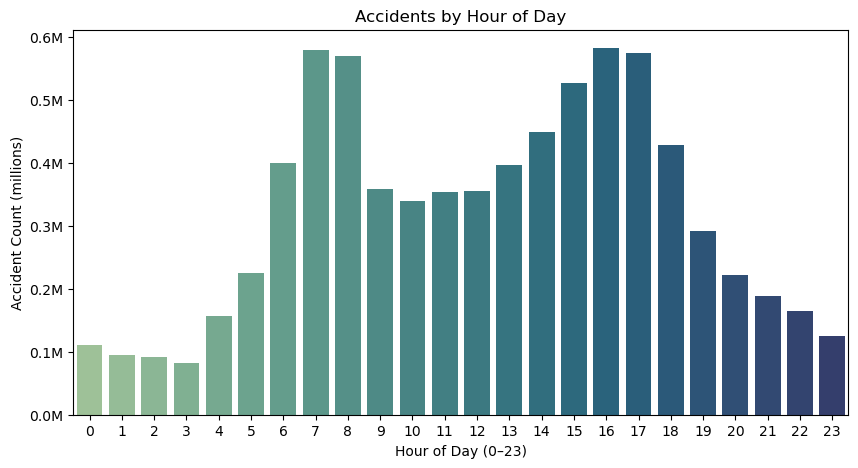


----------------------------------------
Aggregate Incident Duration by Hour of Day
----------------------------------------



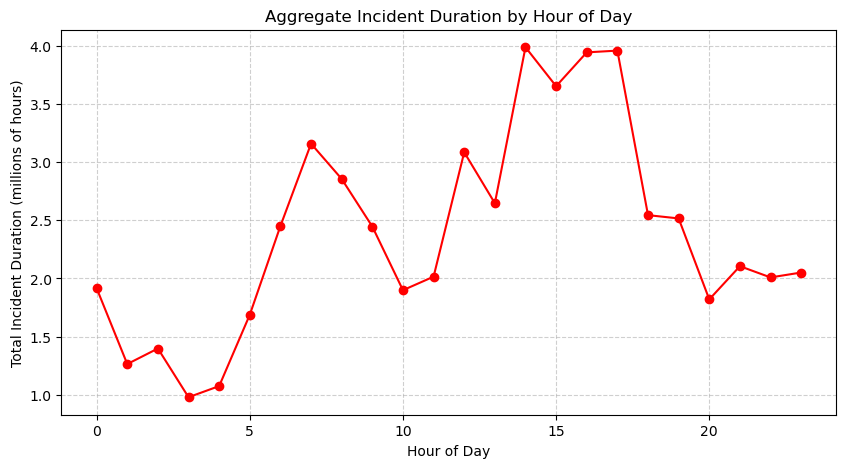


----------------------------------------
Accidents by Day of Week
----------------------------------------



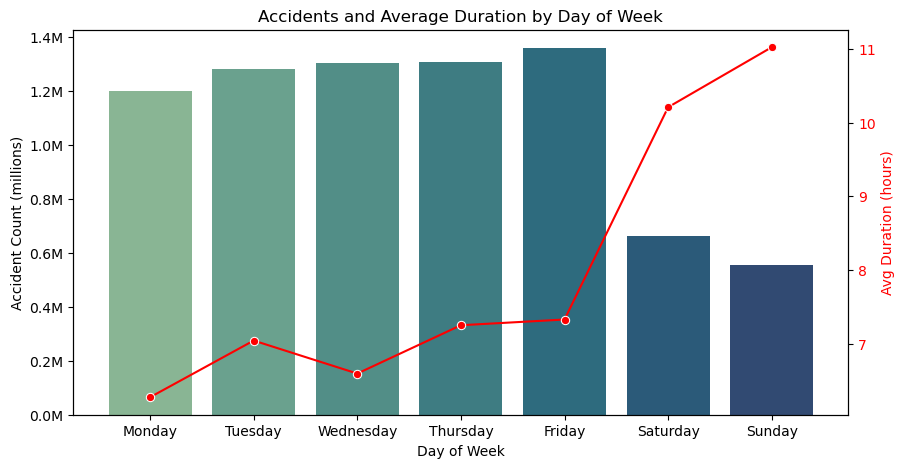


----------------------------------------
Accidents Over Time (Monthly and Yearly Trends)
----------------------------------------



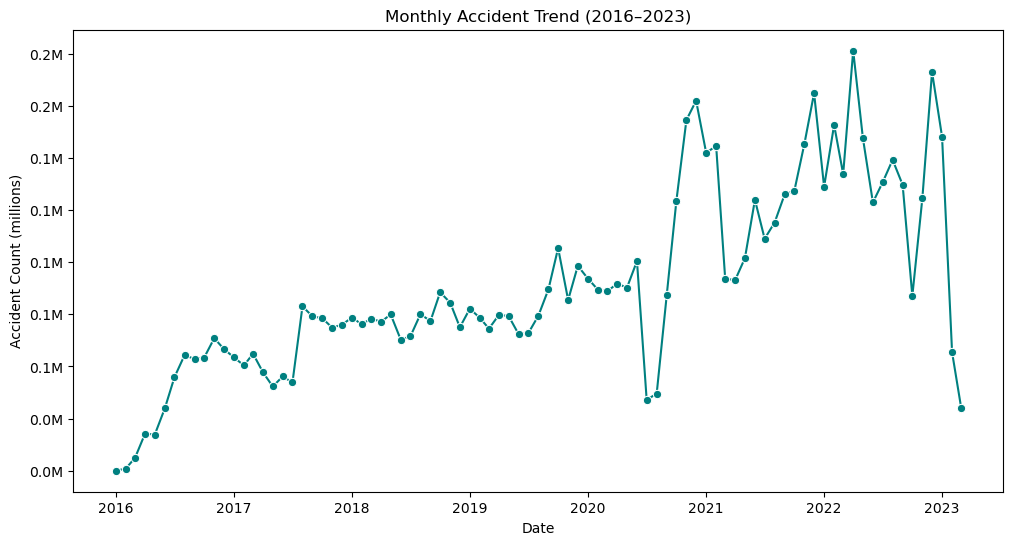


----------------------------------------
Workload Heatmap: Hour vs Day of Week
----------------------------------------



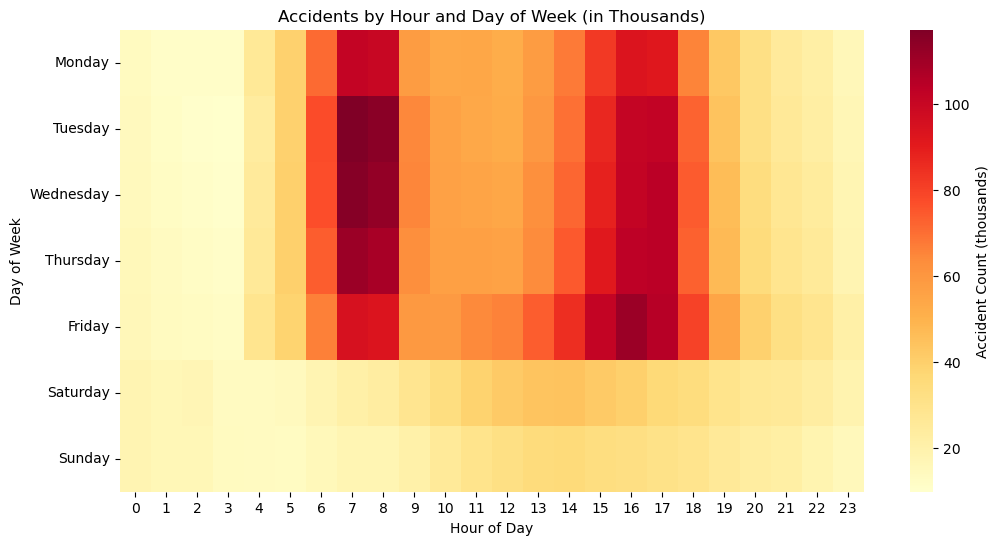


----------------------------------------
Average Duration by Hour (Workload Proxy)
----------------------------------------



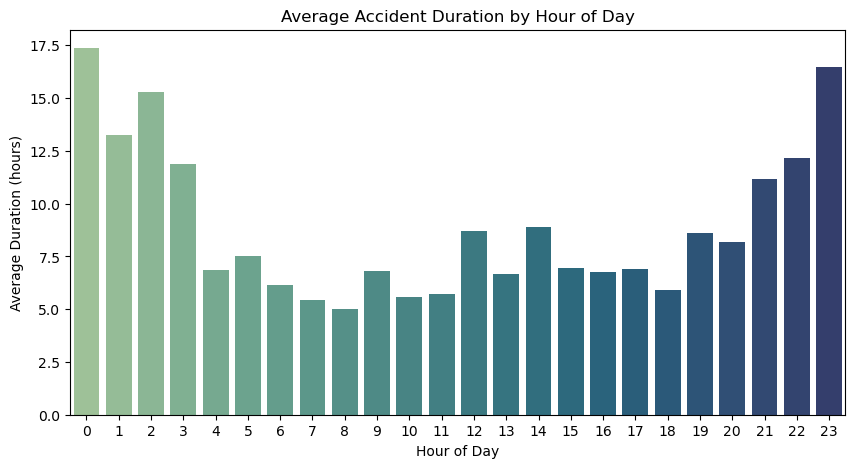


----------------------------------------
Average Severity by Hour
----------------------------------------



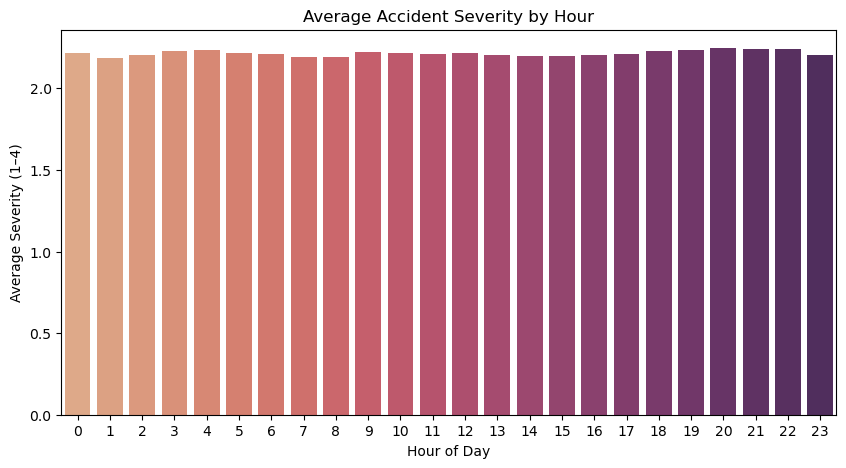


----------------------------------------
Accident Distance Distribution (Log Scale by Severity)
----------------------------------------

Distance (mi) represents how far an accident extended along the roadway — shorter distances usually correspond to localized fender-benders in dense areas, while longer distances often reflect highway closures or multi-vehicle incidents. Analyzing this distribution on a log scale helps reveal both clusters.
Each vertical “violin” represents the distribution of accident distances for one severity level (1 through 4).
•	The width of the shape at a given height shows how common that distance value is. Wider = more accidents at that distance.
•	The horizontal lines inside show quartiles: the middle one is roughly the median, the outer ones are the 25th and 75th percentiles.
•	The y-axis is on a logarithmic scale — so each step upward represents a multiplicative jump (e.g. 0.1 → 1 → 10 miles).


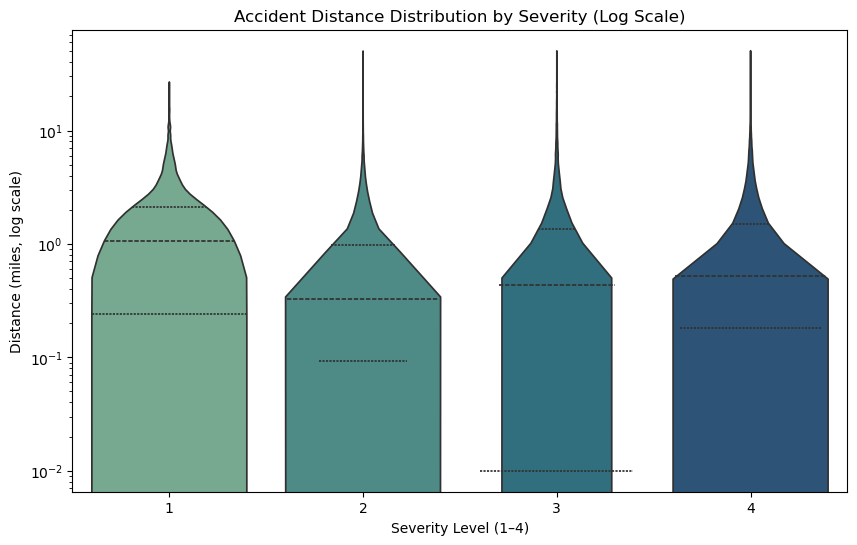


----------------------------------------
Severity and Duration by Distance Band
----------------------------------------

While short-distance incidents often represent minor urban collisions, long-distance incidents may reflect highway events with higher kinetic energy and clearance times. Grouping by distance bands reveals how travel context relates to severity and duration.


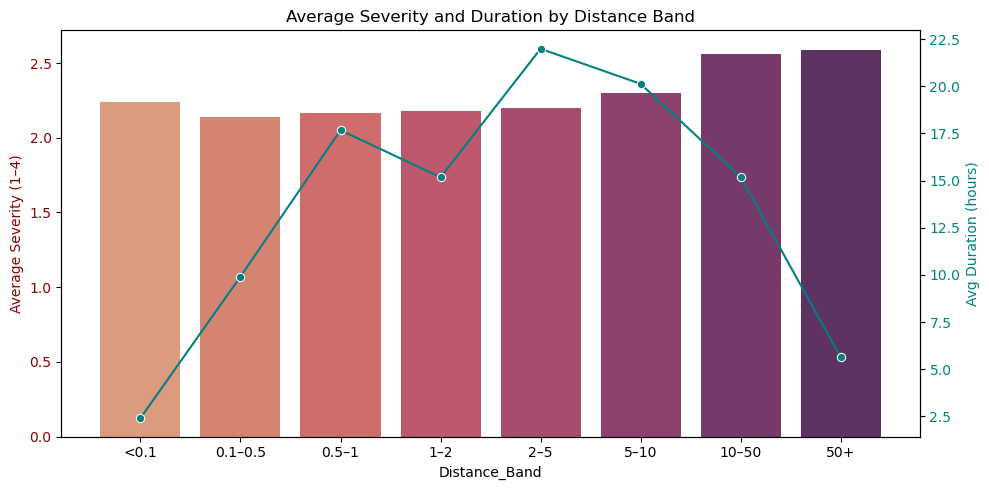

In [90]:
# =====================================================
# TEMPORAL PATTERNS — RESOURCE ALLOCATION FOCUS
# =====================================================
print_heading("Temporal Patterns (Operational Workload)")

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Copy working DataFrame
temp_df = accidents_df.copy()

# ---------------------------------------------
# 1. Accidents by Hour of Day
# ---------------------------------------------
print_sub_heading("Accidents by Hour of Day")

hourly = (
    temp_df.groupby('Hour')
    .agg(Accidents=('ID', 'count'), Total_Duration=('Duration_hours', 'sum'))
    .reset_index()
)

plt.figure(figsize=(10,5))
sns.barplot(data=hourly, x='Hour', y='Accidents', palette='crest')
plt.title("Accidents by Hour of Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Accident Count (millions)")
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1e6:.1f}M"))
plt.show()

print_sub_heading("Aggregate Incident Duration by Hour of Day")

# Group by hour and sum total duration (in hours)
hourly_duration = accidents_df.groupby("Hour")["Duration_hours"].sum()

plt.figure(figsize=(10,5))
plt.plot(hourly_duration.index, hourly_duration.values / 1e6, marker='o', color='red')
plt.title("Aggregate Incident Duration by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Total Incident Duration (millions of hours)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# ---------------------------------------------
# 2. Accidents by Day of Week
# ---------------------------------------------
print_sub_heading("Accidents by Day of Week")

day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
by_day = (
    temp_df.groupby('DayOfWeek')
    .agg(Accidents=('ID', 'count'), Avg_Duration=('Duration_hours', 'mean'))
    .reindex(day_order)
    .reset_index()
)

fig, ax1 = plt.subplots(figsize=(10,5))
sns.barplot(data=by_day, x='DayOfWeek', y='Accidents', palette='crest', ax=ax1)
ax1.set_ylabel("Accident Count (millions)")
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1e6:.1f}M"))
ax1.set_xlabel("Day of Week")
ax1.set_title("Accidents and Average Duration by Day of Week")

# Overlay average duration line
ax2 = ax1.twinx()
sns.lineplot(data=by_day, x='DayOfWeek', y='Avg_Duration', color='red', marker='o', ax=ax2)
ax2.set_ylabel("Avg Duration (hours)", color='red')
ax2.tick_params(axis='y', labelcolor='red')
plt.show()


# ---------------------------------------------
# 3. Accidents by Month and Year
# ---------------------------------------------
print_sub_heading("Accidents Over Time (Monthly and Yearly Trends)")

monthly = (
    temp_df.groupby(['Year','Month'])
    .size()
    .reset_index(name='Accidents')
)
monthly['Date'] = pd.to_datetime(monthly['Year'].astype(str) + '-' + monthly['Month'].astype(str) + '-01')

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly, x='Date', y='Accidents', marker='o', color='teal')
plt.title("Monthly Accident Trend (2016–2023)")
plt.xlabel("Date")
plt.ylabel("Accident Count (millions)")
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1e6:.1f}M"))
plt.show()


# ---------------------------------------------
# 4. Heatmap: Day of Week × Hour (Workload)
# ---------------------------------------------
print_sub_heading("Workload Heatmap: Hour vs Day of Week")

pivot = (
    temp_df.groupby(['DayOfWeek', 'Hour'])
    .agg(Accidents=('ID', 'count'))
    .unstack(fill_value=0)
    .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
    / 1e3  # show in thousands
)

plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap='YlOrRd', cbar_kws={'label': 'Accident Count (thousands)'})
plt.title("Accidents by Hour and Day of Week (in Thousands)")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.xticks(ticks=np.arange(0.5, 24.5), labels=[str(h) for h in range(24)], rotation=0)
plt.show()


# ---------------------------------------------
# 5. Duration by Hour
# ---------------------------------------------
print_sub_heading("Average Duration by Hour (Workload Proxy)")

duration_by_hour = temp_df.groupby('Hour')['Duration_hours'].mean()
plt.figure(figsize=(10,5))
sns.barplot(x=duration_by_hour.index, y=duration_by_hour.values, palette="crest")
plt.title("Average Accident Duration by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Duration (hours)")
plt.show()


# ---------------------------------------------
# 6. Severity by Hour
# ---------------------------------------------
print_sub_heading("Average Severity by Hour")

severity_by_hour = temp_df.groupby('Hour')['Severity'].mean()
plt.figure(figsize=(10,5))
sns.barplot(x=severity_by_hour.index, y=severity_by_hour.values, palette="flare")
plt.title("Average Accident Severity by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Severity (1–4)")
plt.show()


# ---------------------------------------------
# 7. Accident Distance Distribution (Severity Context)
# ---------------------------------------------
print_sub_heading("Accident Distance Distribution (Log Scale by Severity)")

print(
    "Distance (mi) represents how far an accident extended along the roadway — "
    "shorter distances usually correspond to localized fender-benders in dense areas, "
    "while longer distances often reflect highway closures or multi-vehicle incidents. "
    "Analyzing this distribution on a log scale helps reveal both clusters."
)

print(
    "Each vertical “violin” represents the distribution of accident distances for one severity level (1 through 4)."
	"\n•	The width of the shape at a given height shows how common that distance value is. Wider = more accidents at that distance."
	"\n•	The horizontal lines inside show quartiles: the middle one is roughly the median, the outer ones are the 25th and 75th percentiles."
	"\n•	The y-axis is on a logarithmic scale — so each step upward represents a multiplicative jump (e.g. 0.1 → 1 → 10 miles)."
)

# Filter out zeros and extreme outliers
distance_df = accidents_df[(accidents_df["Distance(mi)"] > 0) & (accidents_df["Distance(mi)"] <= 50)]

plt.figure(figsize=(10,6))
sns.violinplot(
    data=distance_df,
    x="Severity", y="Distance(mi)",
    palette="crest", inner="quartile", scale="width"
)
plt.yscale("log")
plt.title("Accident Distance Distribution by Severity (Log Scale)")
plt.xlabel("Severity Level (1–4)")
plt.ylabel("Distance (miles, log scale)")
plt.show()


# -----------------------------------------------------
# Severity and Duration by Distance Band
# -----------------------------------------------------
print_sub_heading("Severity and Duration by Distance Band")

print(
    "While short-distance incidents often represent minor urban collisions, "
    "long-distance incidents may reflect highway events with higher kinetic energy and clearance times. "
    "Grouping by distance bands reveals how travel context relates to severity and duration."
)

# Define distance bins (in miles)
bins = [0, 0.1, 0.5, 1, 2, 5, 10, 50, np.inf]
labels = ["<0.1", "0.1–0.5", "0.5–1", "1–2", "2–5", "5–10", "10–50", "50+"]

dist_df = accidents_df.copy()
dist_df["Distance_Band"] = pd.cut(dist_df["Distance(mi)"], bins=bins, labels=labels, include_lowest=True)

band_summary = (
    dist_df.groupby("Distance_Band")[["Severity", "Duration_hours"]]
    .mean()
    .reset_index()
)

fig, ax1 = plt.subplots(figsize=(10,5))
sns.barplot(data=band_summary, x="Distance_Band", y="Severity", palette="flare", ax=ax1)
ax1.set_ylabel("Average Severity (1–4)", color="darkred")
ax1.tick_params(axis="y", labelcolor="darkred")

ax2 = ax1.twinx()
sns.lineplot(data=band_summary, x="Distance_Band", y="Duration_hours", color="teal", marker="o", ax=ax2)
ax2.set_ylabel("Avg Duration (hours)", color="teal")
ax2.tick_params(axis="y", labelcolor="teal")

plt.title("Average Severity and Duration by Distance Band")
plt.xlabel("Distance Band (miles)")
plt.tight_layout()
plt.show()

### Temporal Takeaways

#### 1. Hourly rhythms
* **Accidents surge during commuting hours**, peaking around **8–9 AM** and again **4–6 PM**, closely tracking workday travel.
* Aggregate incident *duration* also rises during those windows, suggesting compounded congestion when volume and severity align.
* Overnight (midnight–5 AM) remains the quietest period, likely reflecting lower traffic but longer clear times per event.


#### 2. Weekly workload
* **Weekdays dominate volume** — Monday through Friday account for the bulk of accidents.
* **Weekends show fewer incidents**, but the **average duration** of each event increases slightly, likely reflecting staffing lags and slower weekend response cycles.


#### 3. Seasonal and yearly trends
* From **2016 to 2023**, recorded accident counts rose sharply through 2019, dropped during **2020 COVID lockdowns**, and rebounded to near-peak levels by 2022–2023.
* However, **early years (2016–2017)** likely underrepresent true incident volumes due to **incomplete geographic and reporting coverage** in the dataset’s initial collection phase.
* The overall upward slope therefore reflects both **expanded data capture** and **increasing travel activity**, not necessarily a pure rise in underlying accident risk.


#### 4. Combined hourly × daily view (heatmap)
* The **busiest windows** concentrate on **weekday mornings (7–9 AM)** and **afternoons (4–6 PM)**, forming a “commuter belt” of operational strain.
* Sundays are consistently low-activity days.
* This pattern indicates when **traffic management and emergency services** face their highest resource loads.


#### 5. Duration dynamics
* The **average incident duration** grows steadily through the day and peaks **late evening (10 PM–midnight)** — when clearance operations face reduced staffing and visibility.
* Early morning events clear faster, even if they occur on busy routes.


#### 6. Severity stability
* **Average severity is nearly flat across hours**, varying only slightly between 2.0 and 2.3 (on a 1–4 scale).

⠀→ Implies that **when** accidents occur doesn’t strongly affect their seriousness — just their frequency and duration.

#### 7. Distance-based effects
* **Short-distance events (<0.1 mi)** dominate urban congestion patterns — typically low-severity fender-benders.
* **Long-distance closures (>5 mi)** correlate with **higher severity and dramatically longer durations**, consistent with **highway-scale incidents** requiring complex clearance (multi-lane blockages, multi-vehicle pileups).


#### Summary insight

The temporal landscape reveals that risk and workload are driven less by severity shifts and more by volume and context.
Operationally, the most strained windows are weekday commutes and late evenings — prime targets for staffing optimization, sensor monitoring, and proactive traffic rerouting.
It’s worth noting, however, that early dataset years (2016–2017) likely contain partial reporting coverage, so long-term trend slopes should be interpreted as a mix of true growth in incidents and expansion of data collection infrastructure.



---

### Geographic Analysis


Geographic Analysis (Operational Focus)


----------------------------------------
Accidents per 1,000 Residents
----------------------------------------



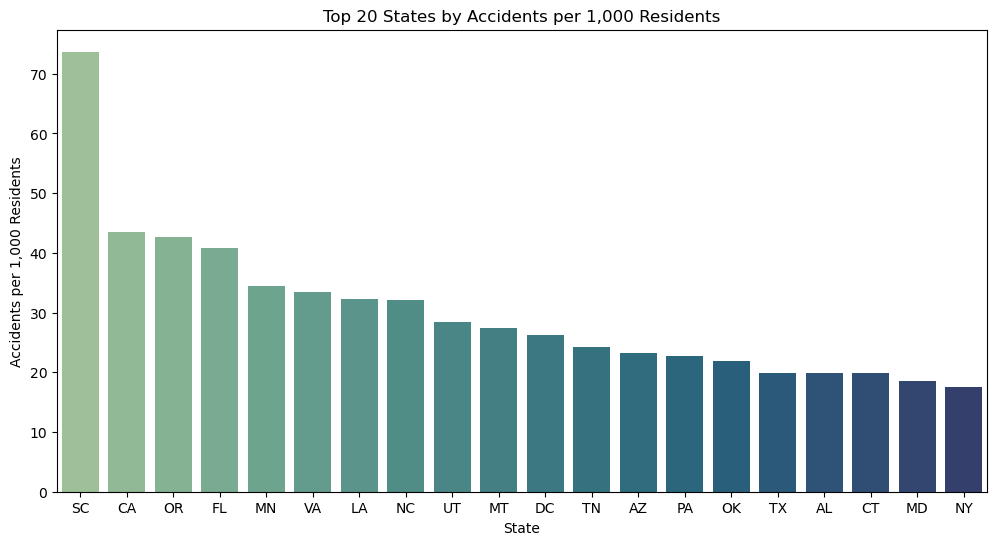


----------------------------------------
Average Severity by State (States with >1,000 Records)
----------------------------------------



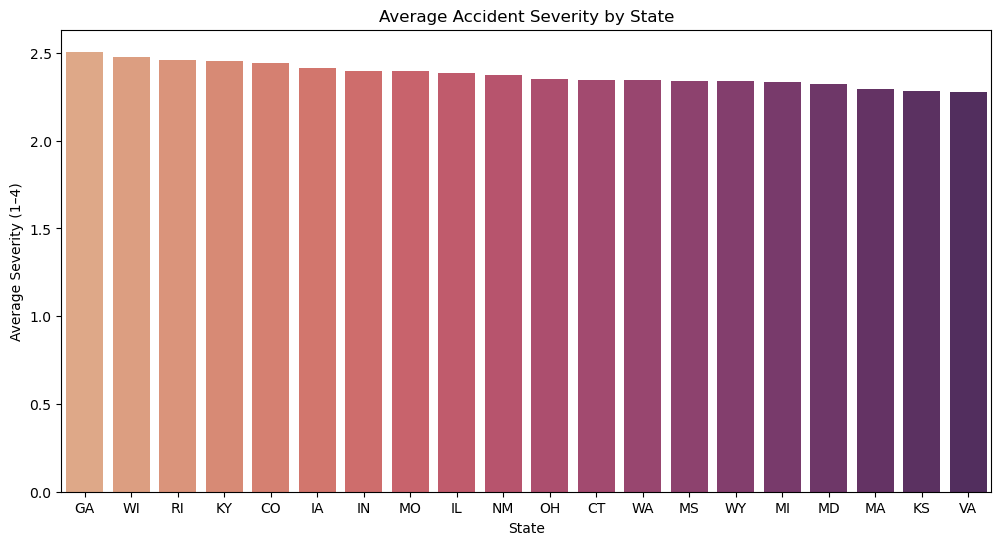


----------------------------------------
Localized Hotspots by City and County
----------------------------------------

While state-level summaries show regional trends, localized city and county hotspots can reveal specific problem zones — often urban choke points or major highway corridors.


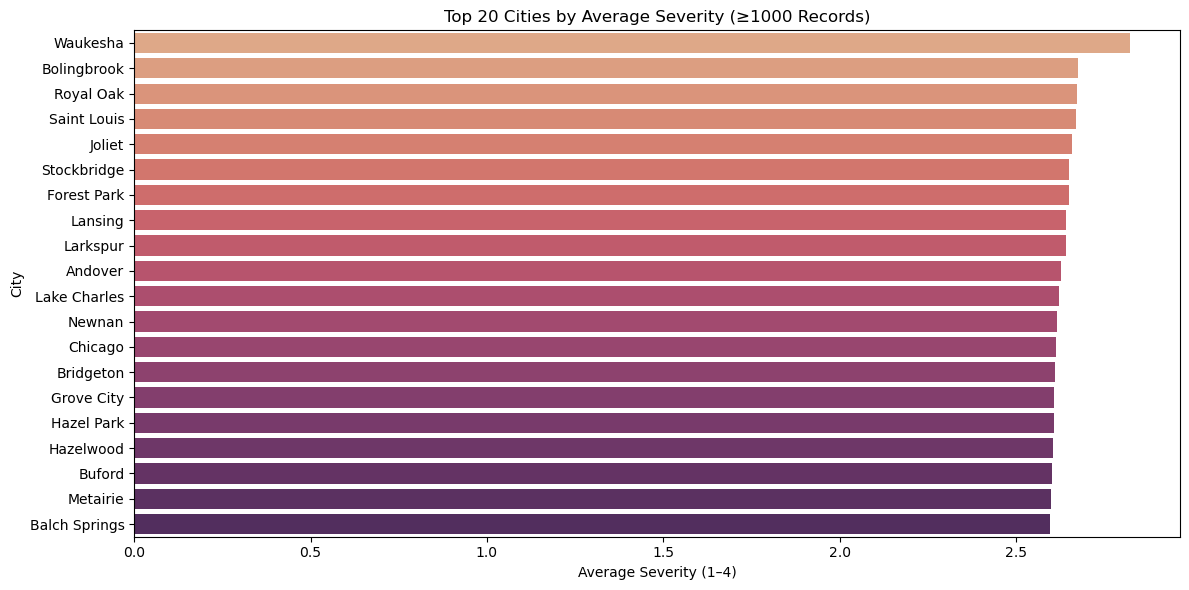

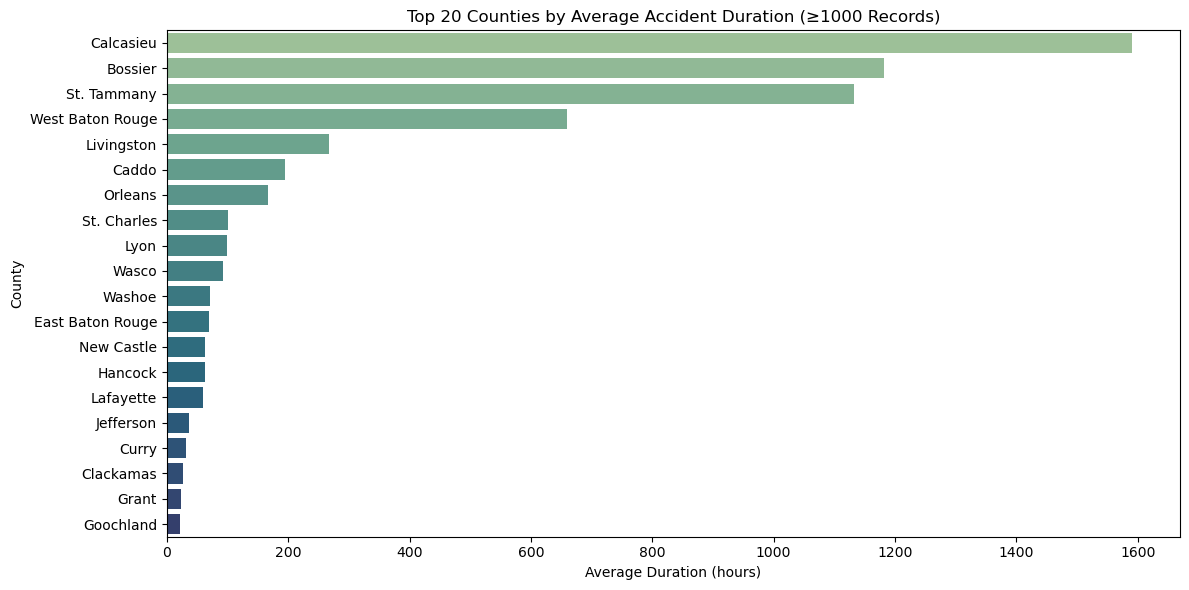


----------------------------------------
Average Accident Duration by State (≤24 Hours)
----------------------------------------



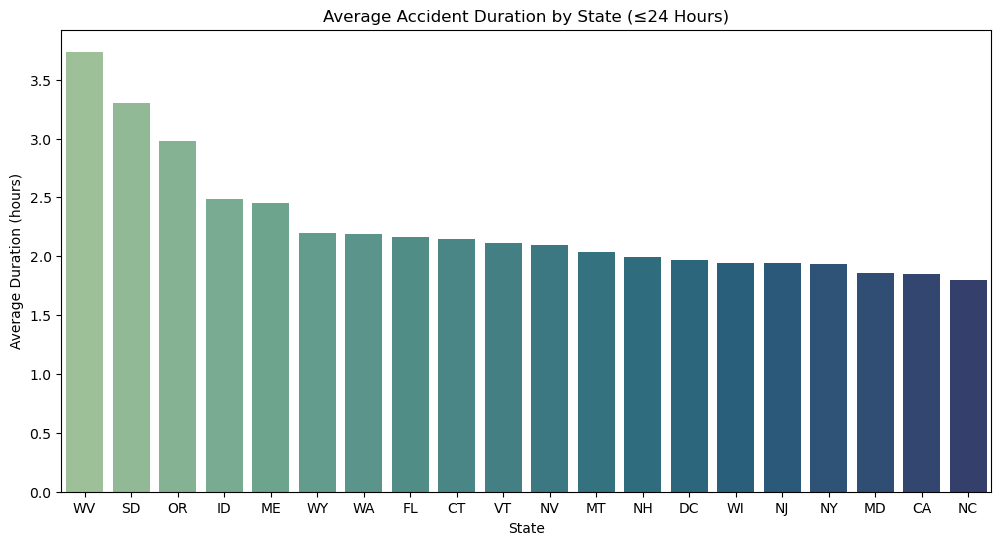


----------------------------------------
Urban vs Suburban vs Rural Analysis
----------------------------------------



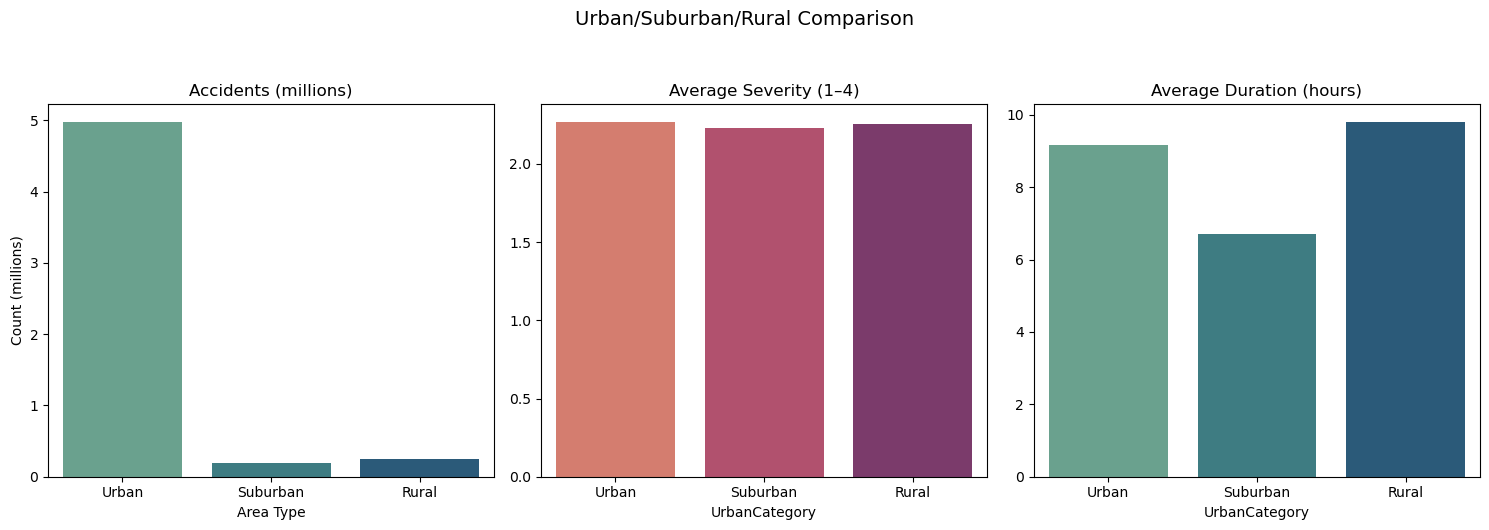


----------------------------------------
Choropleth Map: Accident Density by State
----------------------------------------




----------------------------------------
Severity vs Frequency by State
----------------------------------------



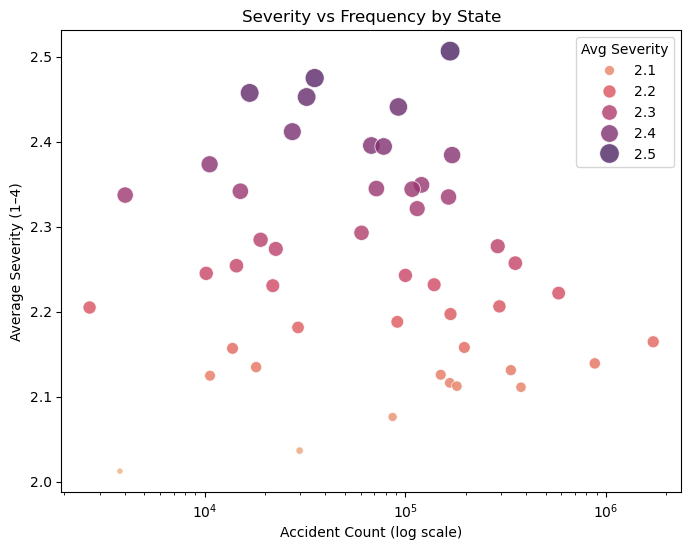

In [98]:
# =====================================================
# GEOGRAPHIC INSIGHTS — OPERATIONAL FOCUS
# =====================================================
print_heading("Geographic Analysis (Operational Focus)")

geo_df = accidents_df.copy()

import matplotlib.ticker as mtick
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# ---------------------------------------------
# 1. Accidents per 1,000 Residents (Top 20 States)
# ---------------------------------------------
print_sub_heading("Accidents per 1,000 Residents")

# Ensure you have a dictionary called state_population = {'CA': 39538223, 'TX': ...}
state_counts = geo_df['State'].value_counts()
state_rate = (state_counts / pd.Series(state_population)) * 1000
state_rate = state_rate.dropna().sort_values(ascending=False).head(20)

plt.figure(figsize=(12,6))
sns.barplot(x=state_rate.index, y=state_rate.values, palette="crest")
plt.title("Top 20 States by Accidents per 1,000 Residents")
plt.xlabel("State")
plt.ylabel("Accidents per 1,000 Residents")
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.show()


# ---------------------------------------------
# 2. Average Severity by State
# ---------------------------------------------
print_sub_heading("Average Severity by State (States with >1,000 Records)")

valid_states = geo_df['State'].value_counts()
valid_states = valid_states[valid_states > 1000].index
filtered = geo_df[geo_df['State'].isin(valid_states)]

state_severity = filtered.groupby('State')['Severity'].mean().sort_values(ascending=False).head(20)

plt.figure(figsize=(12,6))
sns.barplot(x=state_severity.index, y=state_severity.values, palette="flare")
plt.title("Average Accident Severity by State")
plt.xlabel("State")
plt.ylabel("Average Severity (1–4)")
plt.show()


# -----------------------------------------------------
# Localized Hotspots (City and County)
# -----------------------------------------------------
print_sub_heading("Localized Hotspots by City and County")

print(
    "While state-level summaries show regional trends, localized city and county hotspots "
    "can reveal specific problem zones — often urban choke points or major highway corridors."
)

# Top 20 cities by average severity (with ≥1000 records)
city_stats = (
    accidents_df.groupby("City")
    .filter(lambda x: len(x) >= 1000)
    .groupby("City")["Severity"]
    .mean()
    .sort_values(ascending=False)
    .head(20)
)

plt.figure(figsize=(12,6))
sns.barplot(x=city_stats.values, y=city_stats.index, palette="flare")
plt.title("Top 20 Cities by Average Severity (≥1000 Records)")
plt.xlabel("Average Severity (1–4)")
plt.ylabel("City")
plt.tight_layout()
plt.show()

# Top 20 counties by average duration
county_stats = (
    accidents_df.groupby("County")
    .filter(lambda x: len(x) >= 1000)
    .groupby("County")["Duration_hours"]
    .mean()
    .sort_values(ascending=False)
    .head(20)
)

plt.figure(figsize=(12,6))
sns.barplot(x=county_stats.values, y=county_stats.index, palette="crest")
plt.title("Top 20 Counties by Average Accident Duration (≥1000 Records)")
plt.xlabel("Average Duration (hours)")
plt.ylabel("County")
plt.tight_layout()
plt.show()


# ---------------------------------------------
# 3. Average Duration by State (≤24h Filter)
# ---------------------------------------------
print_sub_heading("Average Accident Duration by State (≤24 Hours)")

filtered_duration = geo_df[geo_df['Duration_hours'] <= 24]
duration_by_state = (
    filtered_duration.groupby('State')['Duration_hours']
    .mean()
    .sort_values(ascending=False)
    .head(20)
)

plt.figure(figsize=(12,6))
sns.barplot(x=duration_by_state.index, y=duration_by_state.values, palette="crest")
plt.title("Average Accident Duration by State (≤24 Hours)")
plt.xlabel("State")
plt.ylabel("Average Duration (hours)")
plt.show()


# ---------------------------------------------
# 4. Urban vs Suburban vs Rural — Volume, Severity, Duration
# ---------------------------------------------
print_sub_heading("Urban vs Suburban vs Rural Analysis")

ruca_df_check = geo_df.dropna(subset=['UrbanCategory'])

fig, axes = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle("Urban/Suburban/Rural Comparison", fontsize=14, y=1.05)

# Accident Count
area_counts = ruca_df_check['UrbanCategory'].value_counts().reindex(['Urban','Suburban','Rural'])
sns.barplot(x=area_counts.index, y=area_counts.values/1e6, ax=axes[0], palette="crest")
axes[0].set_title("Accidents (millions)")
axes[0].set_ylabel("Count (millions)")
axes[0].set_xlabel("Area Type")

# Severity
severity_by_area = ruca_df_check.groupby('UrbanCategory')['Severity'].mean().reindex(['Urban','Suburban','Rural'])
sns.barplot(x=severity_by_area.index, y=severity_by_area.values, ax=axes[1], palette="flare")
axes[1].set_title("Average Severity (1–4)")
axes[1].set_ylabel("")

# Duration
duration_by_area = ruca_df_check.groupby('UrbanCategory')['Duration_hours'].mean().reindex(['Urban','Suburban','Rural'])
sns.barplot(x=duration_by_area.index, y=duration_by_area.values, ax=axes[2], palette="crest")
axes[2].set_title("Average Duration (hours)")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()


# ---------------------------------------------
# 5. Geographic Hotspots (Plotly Choropleth)
# ---------------------------------------------
print_sub_heading("Choropleth Map: Accident Density by State")

state_counts_map = geo_df['State'].value_counts().reset_index()
state_counts_map.columns = ['State', 'Accident_Count']

fig = px.choropleth(
    state_counts_map,
    locations="State",
    locationmode="USA-states",
    color="Accident_Count",
    color_continuous_scale="YlOrRd",
    scope="usa",
    title="U.S. Accidents by State (Choropleth View)",
)
fig.update_layout(width=900, height=500)
fig.show()


# ---------------------------------------------
# 6. Severity vs Frequency — State-Level Scatter
# ---------------------------------------------
print_sub_heading("Severity vs Frequency by State")

state_stats = (
    filtered.groupby('State')
    .agg({'Severity': 'mean', 'ID': 'count'})
    .rename(columns={'ID': 'Accident_Count'})
)

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=state_stats,
    x='Accident_Count',
    y='Severity',
    hue='Severity',
    size='Severity',
    sizes=(20,200),
    palette="flare",
    alpha=0.8
)
plt.title("Severity vs Frequency by State")
plt.xlabel("Accident Count (log scale)")
plt.ylabel("Average Severity (1–4)")
plt.xscale('log')
plt.legend(title="Avg Severity")
plt.show()


### Geographic Takeaways

#### 1. National and State-Level Overview
* **California, Texas, and Florida** dominate total crash volume, consistent with their population and vehicle density.
* When normalized per capita, **Midwestern and Southeastern states (e.g., MO, KY, AL, MS)** show **higher accidents per 1,000 residents**, suggesting regional exposure risks beyond population size.
* The **choropleth map** confirms this pattern — coastal states dominate absolute counts, while interior regions reveal higher relative risk.


#### 2. Severity and Duration by State
* **Average severity** remains tightly clustered (≈2.1–2.5), indicating similar injury potential across states.
* **West Virginia and South Dakota** lead in **average duration**, often exceeding 3 hours, hinting at **slower clearances in rural or mountainous terrain** with limited access routes.
* States with shorter durations (e.g., **North Carolina, Maryland**) may benefit from **denser infrastructure and quicker emergency response**.


#### 3. Frequency vs. Severity Relationship
* The scatter plot shows **no strong correlation** between a state’s accident frequency and average severity — high-volume states like CA and TX do not necessarily have more severe crashes.

⠀→ Implies that **incident management and infrastructure**, not just exposure, drive severity outcomes.

#### 4. Localized Hotspots
* **Cities such as Washington D.C., St. Louis, and San Diego** rank highest in average severity.
* County-level duration leaders (e.g., **Clackamas, OR; St. Tammany, LA**) reveal **persistent bottlenecks** likely tied to limited alternate routes or regional weather impacts.
* These micro-level variations highlight **where regional agencies could focus mitigation** (traffic signal coordination, winter response, detour planning).


#### 5. Urban–Suburban–Rural Dynamics
* **Urban areas** dominate in **accident counts**, as expected from higher traffic volumes.
* **Severity** rises slightly in **rural zones**, likely tied to higher speeds and delayed response times.
* **Average duration** is also longest in **rural areas**, reinforcing the operational strain of distance, terrain, and resource availability.


#### Summary insight

The geographic distribution of accidents reveals a dual story:
Urban density drives **volume**, while rural isolation drives **duration and severity**.
National-level aggregates mask these localized contrasts — emphasizing the need for **region-specific resource planning and infrastructure adaptation**.

### 

---

### Environmental Analysis


Environmental Factors (Operational Risk & Resource Demand)


----------------------------------------
Calculating Accident Summary by Weather Condition
----------------------------------------


----------------------------------------
Top Weather Conditions by Response Burden
----------------------------------------

Response Burden represents the total operational load associated with each weather condition.
It combines accident frequency, average severity, and average duration to estimate overall strain on response resources.
Higher values indicate conditions that demand more total response time and coordination across the network.


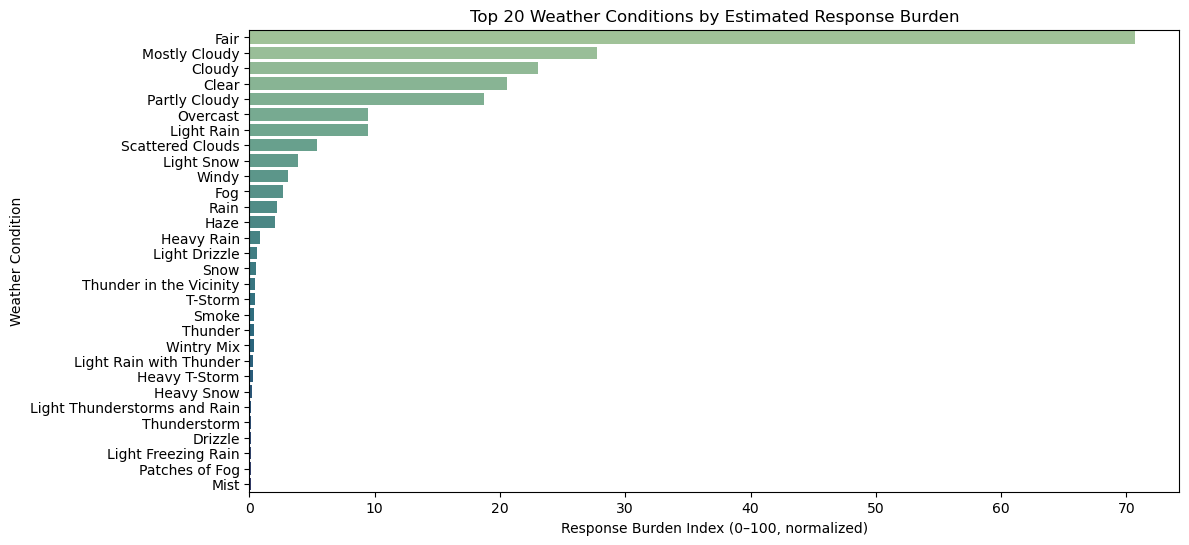


----------------------------------------
Per-Incident Response Burden (Normalized Severity × Duration)
----------------------------------------

Operational Burden represents how demanding a weather condition is on response resources.
It combines how severe and prolonged accidents tend to be under each condition.
This per-incident view ignores total frequency, focusing instead on how costly each crash is individually.


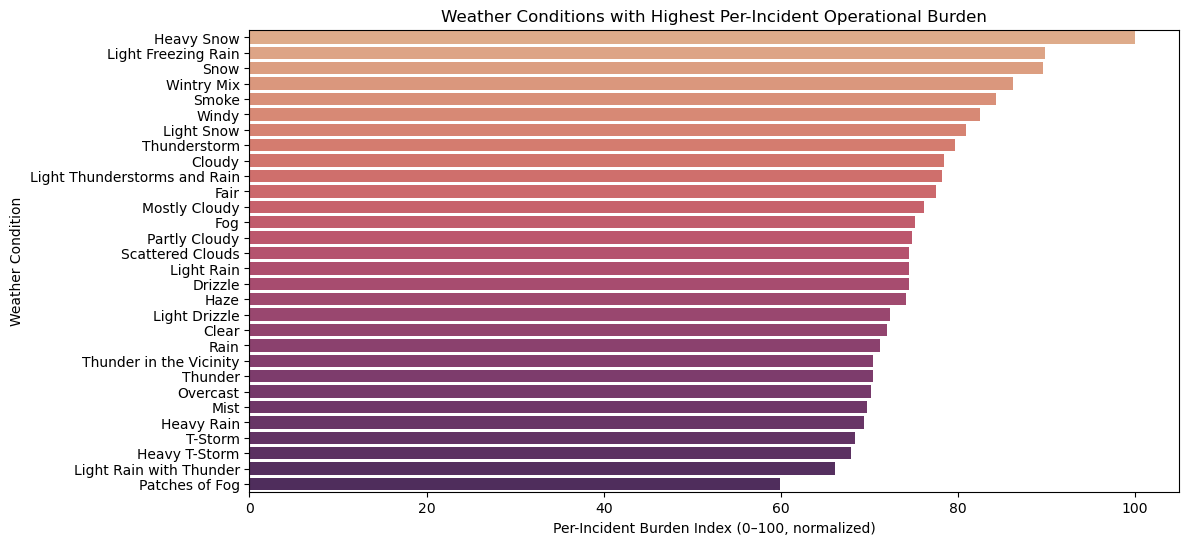


----------------------------------------
Operational Risk Matrix: Frequency × Severity × Duration
----------------------------------------

Operational Risk represents the combined impact of accident frequency, severity, and duration under each weather condition — effectively capturing how demanding each condition is on response resources.


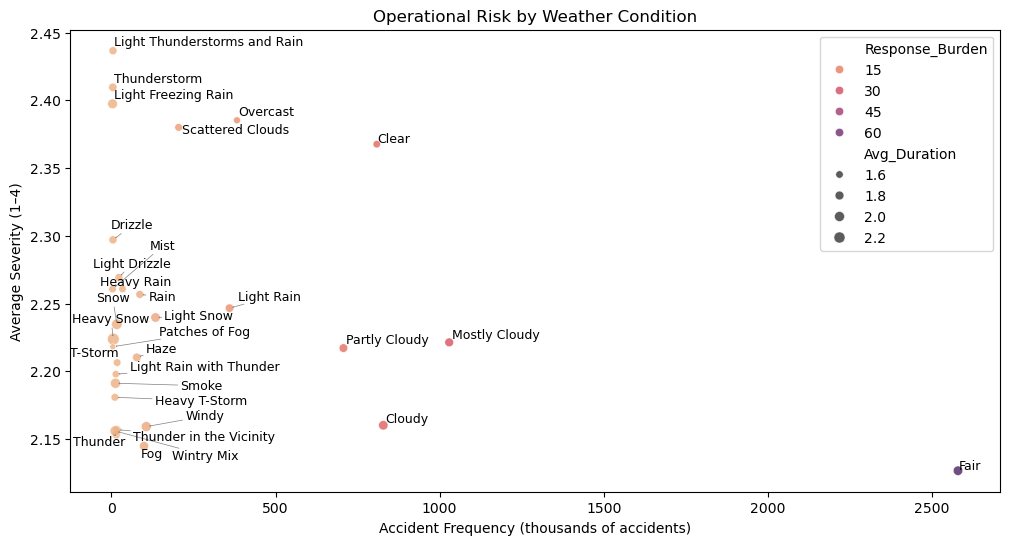


----------------------------------------
Accident Frequency vs Average Duration
----------------------------------------



/var/folders/ch/63xjc1fn56v6flb88p6278j80000gn/T/ipykernel_17693/3721707311.py:154: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



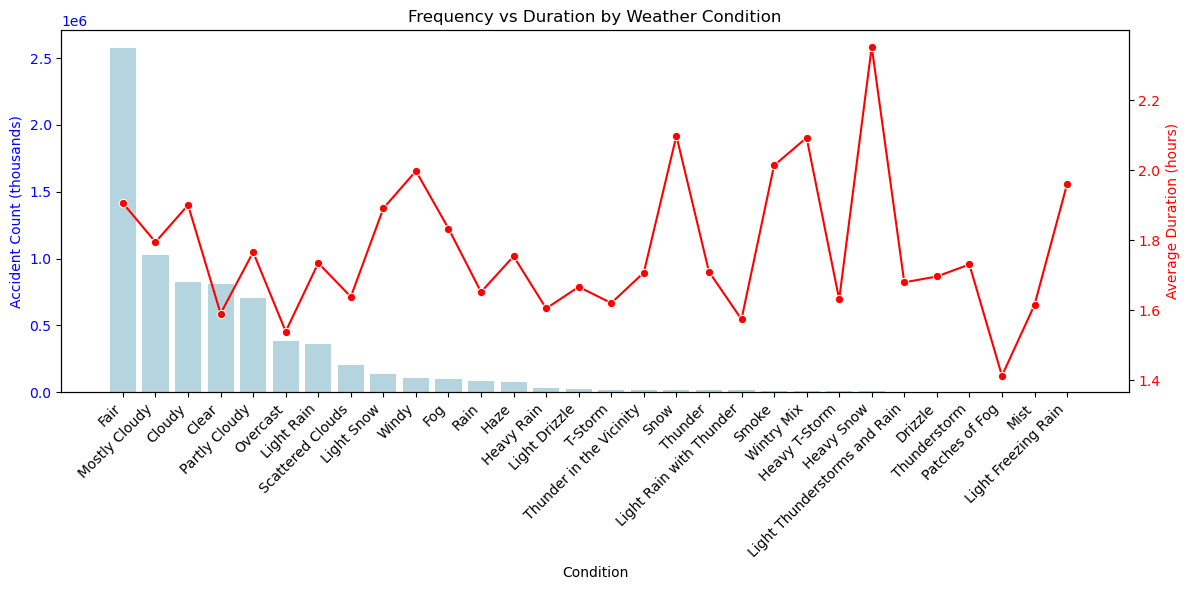


----------------------------------------
Summary Table: Frequency, Severity, Duration, Response Burden
----------------------------------------



,Condition,Accident_Count,Avg_Severity,Avg_Duration,Response_Burden
0,Fair,2579163,2.126699,1.905545,70.700087
1,Mostly Cloudy,1029096,2.221420,1.794231,27.744747
2,Cloudy,828355,2.160239,1.900234,23.000708
3,Clear,808369,2.367644,1.590133,20.586158
4,Partly Cloudy,706922,2.217211,1.765532,18.718451
5,Overcast,382686,2.385285,1.538703,9.500652
6,Light Rain,359761,2.246675,1.734357,9.482187
7,Scattered Clouds,204768,2.380069,1.637973,5.399756
8,Light Snow,134380,2.239775,1.890751,3.849366
9,Windy,106311,2.159250,1.997401,3.101431



----------------------------------------
Twilight and Light Conditions
----------------------------------------

Twilight phases affect visibility and driver alertness. Analyzing severity by civil, nautical, and astronomical twilight phases helps capture transition-light risks.


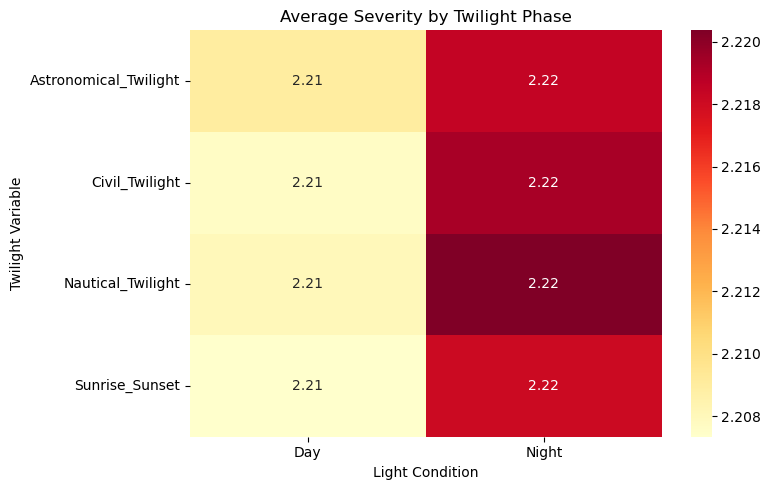


----------------------------------------
Combined Risk: Day/Night × Weather Condition
----------------------------------------

Certain weather conditions are far more dangerous at night — fog, rain, and snow reduce visibility and increase response difficulty. This heatmap compares average severity across Day vs Night for each major weather type.


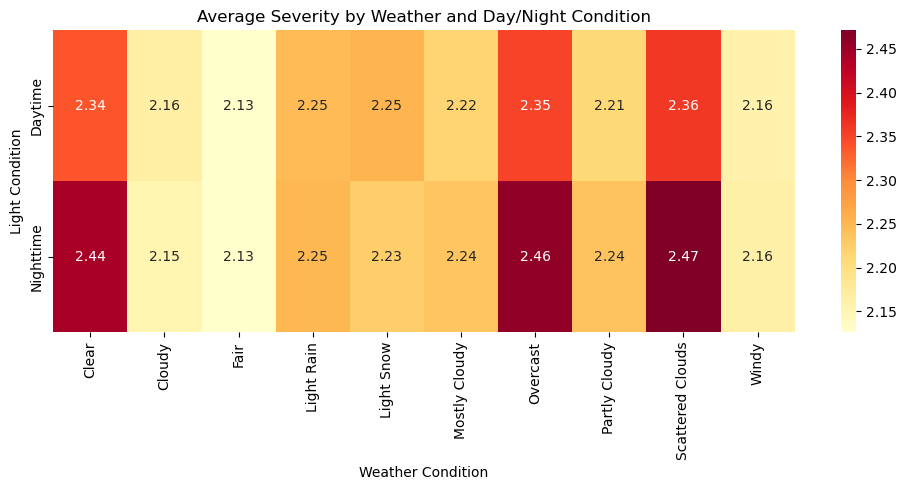


----------------------------------------
Wind Speed and Direction Influence on Severity
----------------------------------------

Wind speed and direction can indirectly affect accident risk — strong winds reduce stability for high-profile vehicles, while crosswinds may increase lane drift incidents. This section examines their relationship to severity.


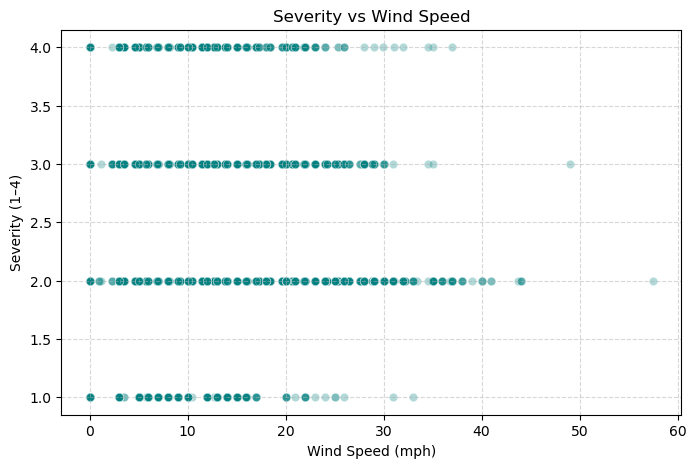

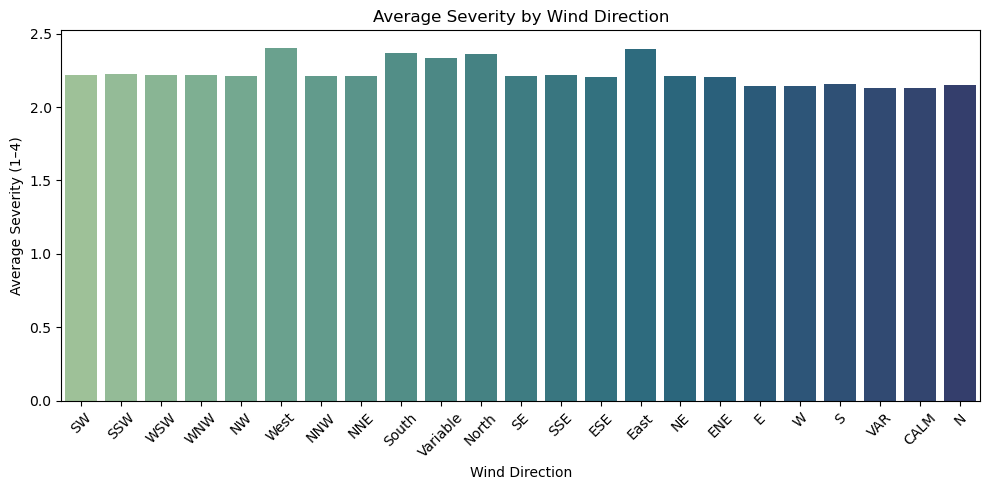


----------------------------------------
Feature Correlation Heatmap (Environmental & Outcome Variables)
----------------------------------------



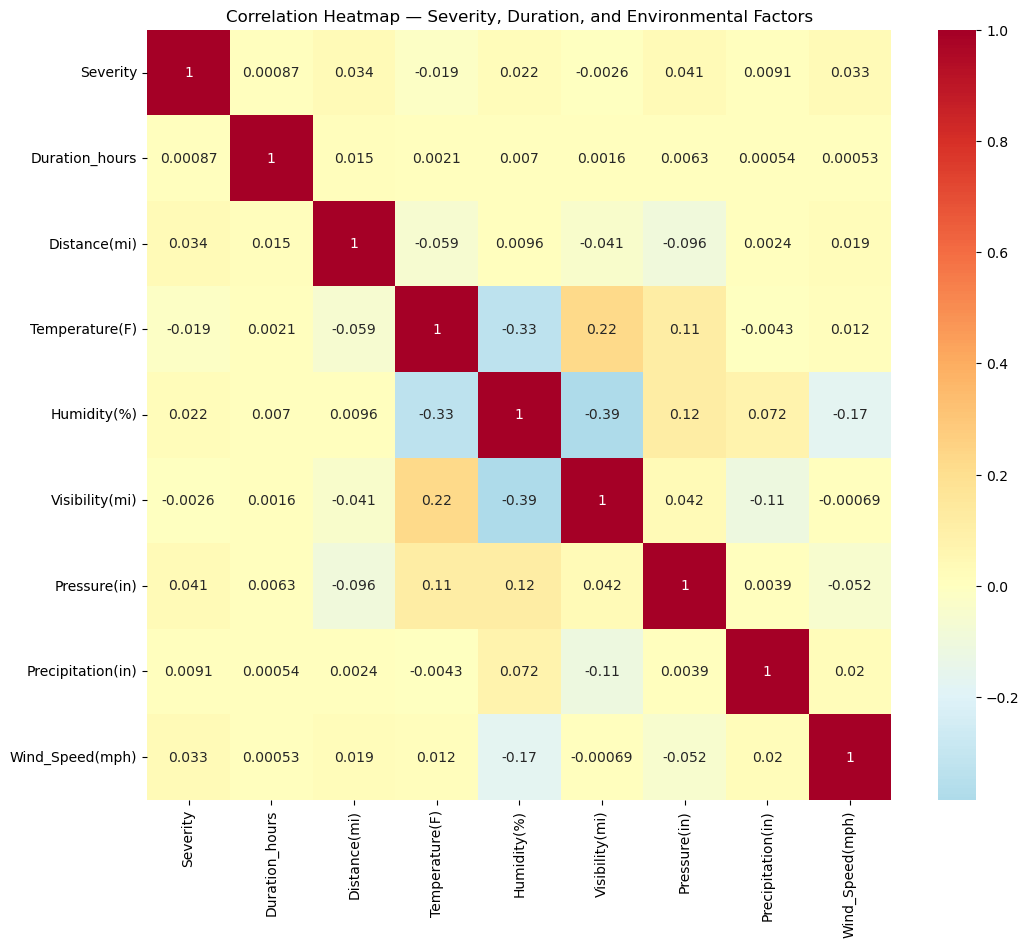

In [95]:
# =====================================================
# ENVIRONMENTAL FACTORS — OPERATIONAL RISK ANALYSIS
# =====================================================
print_heading("Environmental Factors (Operational Risk & Resource Demand)")

env_df = accidents_df.copy()

# Filter unrealistic durations
env_df = env_df[env_df["Duration_hours"] <= 24]

# Drop rows without condition info
env_df = env_df.dropna(subset=["Condition"])

# -----------------------------------------------------
# 1. Summary by Condition
# -----------------------------------------------------
print_sub_heading("Calculating Accident Summary by Weather Condition")

weather_summary = (
    env_df.groupby("Condition")
    .agg(
        Accident_Count=("ID", "count"),
        Avg_Severity=("Severity", "mean"),
        Avg_Duration=("Duration_hours", "mean"),
    )
    .reset_index()
)

# Filter for the 20 most frequent conditions
weather_summary = weather_summary.sort_values("Accident_Count", ascending=False).head(30)

# Compute a normalized Response Burden Index
weather_summary["Response_Burden"] = (
    (weather_summary["Accident_Count"] * weather_summary["Avg_Severity"] * weather_summary["Avg_Duration"])
    / (weather_summary["Accident_Count"].max()
       * weather_summary["Avg_Severity"].max()
       * weather_summary["Avg_Duration"].max())
) * 100

# -----------------------------------------------------
# 2. Barplot: Top Conditions by Response Burden
# -----------------------------------------------------
print_sub_heading("Top Weather Conditions by Response Burden")

print(
    "Response Burden represents the total operational load associated with each weather condition.\n"
    "It combines accident frequency, average severity, and average duration to estimate overall strain on response resources.\n"
    "Higher values indicate conditions that demand more total response time and coordination across the network."
)

plt.figure(figsize=(12,6))
sns.barplot(
    data=weather_summary.sort_values("Response_Burden", ascending=False),
    y="Condition", x="Response_Burden", palette="crest"
)
plt.title("Top 20 Weather Conditions by Estimated Response Burden")
plt.xlabel("Response Burden Index (0–100, normalized)")
plt.ylabel("Weather Condition")
plt.show()


# -------------------------------------------------------------------
# 2b. Average (Per-Incident) Response Burden
# -------------------------------------------------------------------
print_sub_heading("Per-Incident Response Burden (Normalized Severity × Duration)")

print(
    "Operational Burden represents how demanding a weather condition is on response resources.\n"
    "It combines how severe and prolonged accidents tend to be under each condition.\n"
    "This per-incident view ignores total frequency, focusing instead on how costly each crash is individually."
)


# Use the correct column name depending on your dataset
condition_col = "Weather_Condition" if "Weather_Condition" in weather_summary.columns else "Condition"

# Compute per-incident operational burden — ignores total frequency
weather_summary["Per_Incident_Burden"] = (
    weather_summary["Avg_Severity"] * weather_summary["Avg_Duration"]
)

# Normalize to 0–100 for interpretability
weather_summary["Per_Incident_Burden_Norm"] = (
    weather_summary["Per_Incident_Burden"] /
    weather_summary["Per_Incident_Burden"].max() * 100
)

plt.figure(figsize=(12,6))
sns.barplot(
    data=weather_summary.sort_values("Per_Incident_Burden_Norm", ascending=False),
    y=condition_col, x="Per_Incident_Burden_Norm", palette="flare"
)
plt.title("Weather Conditions with Highest Per-Incident Operational Burden")
plt.xlabel("Per-Incident Burden Index (0–100, normalized)")
plt.ylabel("Weather Condition")
plt.show()


# -----------------------------------------------------
# 3. Bubble Chart: Frequency × Severity × Duration
# -----------------------------------------------------
print_sub_heading("Operational Risk Matrix: Frequency × Severity × Duration")

print(
    "Operational Risk represents the combined impact of accident frequency, severity, and "
    "duration under each weather condition — effectively capturing how demanding each condition "
    "is on response resources."
)

from adjustText import adjust_text

plt.figure(figsize=(12,6))
sns.scatterplot(
    data=weather_summary,
    x=weather_summary["Accident_Count"]/1000,
    y="Avg_Severity",
    size="Avg_Duration",
    hue="Response_Burden",
    palette="flare",
    alpha=0.8,
    legend="brief"
)

plt.title("Operational Risk by Weather Condition")
plt.xlabel("Accident Frequency (thousands of accidents)")
plt.ylabel("Average Severity (1–4)")

texts = [
    plt.text(
        row["Accident_Count"]/1000,
        row["Avg_Severity"],
        row["Condition"],  # ← fixed here
        fontsize=9
    )
    for _, row in weather_summary.iterrows()
]

adjust_text(texts, arrowprops=dict(arrowstyle="->", color='gray', lw=0.5))
plt.show()


# -----------------------------------------------------
# 4. Dual-Axis Plot — Frequency vs Duration
# -----------------------------------------------------
print_sub_heading("Accident Frequency vs Average Duration")

fig, ax1 = plt.subplots(figsize=(12,6))
sns.barplot(
    data=weather_summary,
    x="Condition", y="Accident_Count", color="lightblue", ax=ax1
)
ax1.set_ylabel("Accident Count (thousands)", color="blue")
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

ax2 = ax1.twinx()
sns.lineplot(
    data=weather_summary,
    x="Condition", y="Avg_Duration", color="red", marker="o", ax=ax2
)
ax2.set_ylabel("Average Duration (hours)", color="red")
ax2.tick_params(axis='y', labelcolor='red')
plt.title("Frequency vs Duration by Weather Condition")
plt.tight_layout()
plt.show()


# -----------------------------------------------------
# 5. Summary Table
# -----------------------------------------------------
print_sub_heading("Summary Table: Frequency, Severity, Duration, Response Burden")

display(
    weather_summary[["Condition", "Accident_Count", "Avg_Severity", "Avg_Duration", "Response_Burden"]]
    .sort_values("Response_Burden", ascending=False)
    .reset_index(drop=True)
)


# -----------------------------------------------------
# Twilight and Light Conditions
# -----------------------------------------------------
print_sub_heading("Twilight and Light Conditions")

print(
    "Twilight phases affect visibility and driver alertness. "
    "Analyzing severity by civil, nautical, and astronomical twilight phases helps capture transition-light risks."
)

twilight_cols = ["Sunrise_Sunset", "Civil_Twilight", "Nautical_Twilight", "Astronomical_Twilight"]
twilight_df = accidents_df[twilight_cols + ["Severity"]].dropna()

# Fix: keep Severity as an id variable
avg_twilight = (
    twilight_df.melt(id_vars="Severity", var_name="Phase", value_name="Condition")
    .groupby(["Phase", "Condition"])["Severity"]
    .mean()
    .unstack()
)

plt.figure(figsize=(8,5))
sns.heatmap(avg_twilight, annot=True, cmap="YlOrRd", fmt=".2f")
plt.title("Average Severity by Twilight Phase")
plt.xlabel("Light Condition")
plt.ylabel("Twilight Variable")
plt.tight_layout()
plt.show()


# -----------------------------------------------------
# 5b. Combined Risk: Day/Night × Weather Condition
# -----------------------------------------------------
print_sub_heading("Combined Risk: Day/Night × Weather Condition")

print(
    "Certain weather conditions are far more dangerous at night — "
    "fog, rain, and snow reduce visibility and increase response difficulty. "
    "This heatmap compares average severity across Day vs Night for each major weather type."
)

# Simplify to day/night classification
env_df["Light_Condition"] = env_df["Sunrise_Sunset"].map({
    "Day": "Daytime", "Night": "Nighttime"
})

# Keep common weather categories
top_conditions = env_df["Condition"].value_counts().head(10).index
combo_df = env_df[env_df["Condition"].isin(top_conditions)]

# Compute average severity by condition × light
pivot_combo = (
    combo_df.groupby(["Light_Condition", "Condition"])["Severity"]
    .mean()
    .unstack()
    .loc[["Daytime", "Nighttime"]]  # consistent order
)

plt.figure(figsize=(10,5))
sns.heatmap(pivot_combo, annot=True, cmap="YlOrRd", fmt=".2f")
plt.title("Average Severity by Weather and Day/Night Condition")
plt.xlabel("Weather Condition")
plt.ylabel("Light Condition")
plt.tight_layout()
plt.show()

# -----------------------------------------------------
# Wind Speed and Direction Influence
# -----------------------------------------------------
print_sub_heading("Wind Speed and Direction Influence on Severity")

print(
    "Wind speed and direction can indirectly affect accident risk — strong winds reduce stability for high-profile vehicles, "
    "while crosswinds may increase lane drift incidents. This section examines their relationship to severity."
)

# Filter out extreme values
wind_df = accidents_df.copy()
wind_df = wind_df[wind_df["Wind_Speed(mph)"].between(0, 80)]

# Scatter: Wind speed vs severity
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=wind_df.sample(50000, random_state=42),
    x="Wind_Speed(mph)", y="Severity",
    alpha=0.3, color="teal"
)
plt.title("Severity vs Wind Speed")
plt.xlabel("Wind Speed (mph)")
plt.ylabel("Severity (1–4)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# Average severity by wind direction
plt.figure(figsize=(10,5))
sns.barplot(
    data=wind_df,
    x="Wind_Direction", y="Severity",
    estimator="mean", errorbar=None, palette="crest"
)
plt.title("Average Severity by Wind Direction")
plt.xlabel("Wind Direction")
plt.ylabel("Average Severity (1–4)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -----------------------------------------------------
# 6. Correlation Heatmap: Environmental and Outcome Variables
# -----------------------------------------------------
print_sub_heading("Feature Correlation Heatmap (Environmental & Outcome Variables)")

num_cols = [
    'Severity', 'Duration_hours', 'Distance(mi)', 'Temperature(F)',
    'Humidity(%)', 'Visibility(mi)', 'Pressure(in)', 'Precipitation(in)',
    'Wind_Speed(mph)'
]

corr = accidents_df[num_cols].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap='RdYlBu_r', center=0)
plt.title("Correlation Heatmap — Severity, Duration, and Environmental Factors")
plt.show()




### Enviornmental Takeaways


#### 1. Weather-Driven Operational Burden
* **Cloudy and fair-weather conditions** dominate raw accident volume — unsurprising, since most driving happens in them.
* But **rain, snow, fog, and thunderstorms** carry **outsized operational burdens** due to slower clearance times and higher severity per event.
* **Heavy rain, fog, and light snow** emerge as top per-incident burdens — indicating conditions that disrupt both visibility and emergency response.


#### 2. Per-Incident Risk (Severity × Duration)
* Weather types with **moderate frequency but high duration**, such as *Heavy Rain* and *Light Snow*, create **response bottlenecks** disproportionate to their count.
* **Thunderstorms** and **fog** stand out as high-risk conditions, with long incident durations and elevated severity, especially under reduced visibility.


#### 3. Light and Twilight Conditions
* Severity shows a mild uptick during **nighttime and twilight** periods, confirming that **low visibility** consistently worsens outcomes.
* **Civil and nautical twilight** periods (dusk/dawn) slightly exceed daytime averages — the transition zones between light and dark are notably risky for drivers.


#### 4. Wind and Directional Influence
* **High wind speeds** correlate with more severe outcomes, particularly for open-highway or high-profile vehicles.
* Certain directions (notably **SW and W winds**) show slightly elevated averages, likely reflecting regional weather fronts rather than intrinsic directionality.


#### 5. Correlation Overview
* **Severity** is weakly correlated with **duration**, indicating that long incidents aren’t always the most severe — many are low-impact closures or slow recoveries.
* **Visibility** and **humidity** show modest negative correlations with severity — poorer visibility tends to increase severity, while higher humidity tends to coincide with more accidents but slightly lower average severity (rain dampening speed).
* **Precipitation** correlates most strongly with **duration**, reinforcing that weather primarily impacts *response time* rather than *impact intensity.*


#### Summary insight

Environmental factors exert their strongest influence through **operational disruption**, not necessarily direct severity escalation.
Storms, fog, and low light slow clearance and elevate total response load, turning even minor incidents into major drains on resources.
This suggests a **dual mitigation strategy** — one aimed at **driver behavior (visibility awareness)** and another at **response readiness during weather transitions**.



---

### Infrastructure Analysis


Infrastructure Considerations


----------------------------------------
Infrastructure Features in Dataset
----------------------------------------

Evaluating 13 infrastructure-related columns.


Traffic_Signal     1136971
Crossing            871719
Junction            566185
Stop                212464
Station             200612
Amenity              95690
Railway              65793
Give_Way             36045
No_Exit              19510
Traffic_Calming       7561
Bump                  3516
Roundabout             246
Turning_Loop             0
dtype: int64


----------------------------------------
Average Severity and Duration by Infrastructure Feature
----------------------------------------

The Infrastructure Risk Index quantifies how demanding each road feature is on response operations. It is calculated as the normalized product of accident frequency, average severity, and average duration for each feature:

    Risk Index = (Frequency × Severity × Duration) / Max(Frequency × Severity × Duration) × 100

This allows direct comparison across features such as signals, crossings, and junctions — highlighting which designs or control points carry the greatest operational burden.

----------------------------------------
Infrastructure Features by Frequency and Risk
----------------------------------------



/var/folders/ch/63xjc1fn56v6flb88p6278j80000gn/T/ipykernel_17693/2123547001.py:71: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



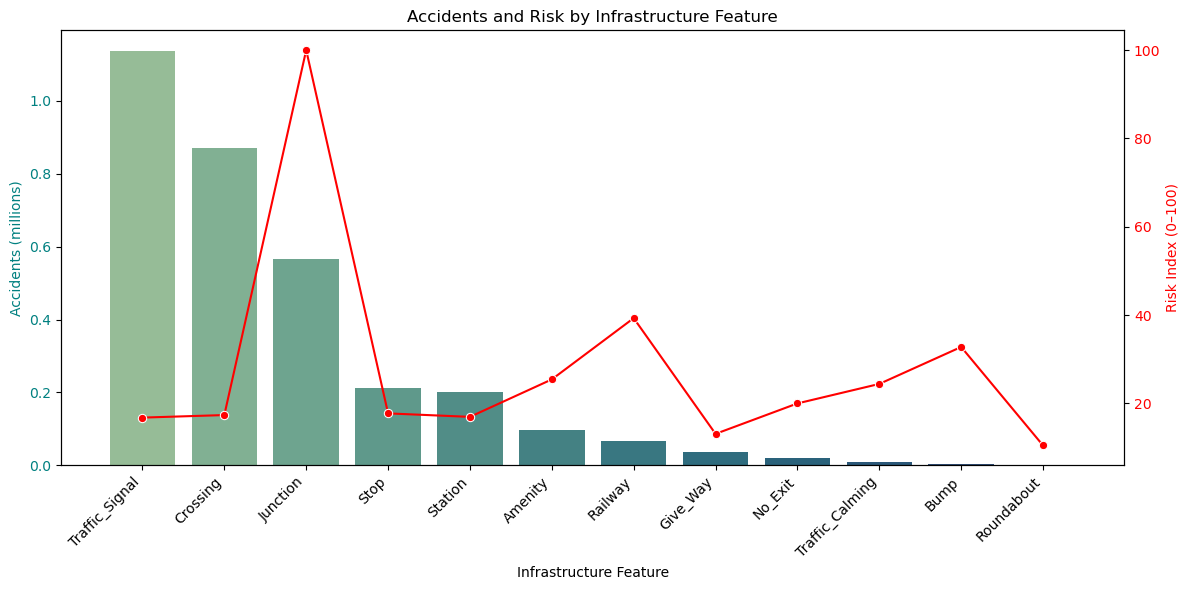


----------------------------------------
Severity vs Duration (Infrastructure Correlation)
----------------------------------------



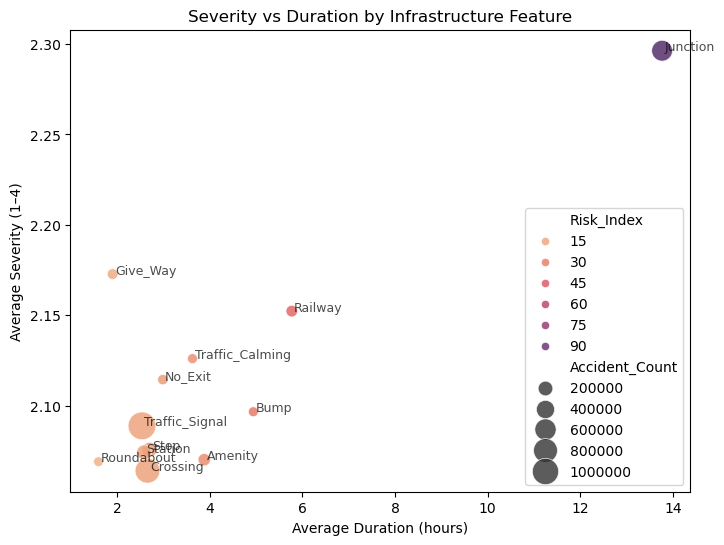


----------------------------------------
Top Risk-Weighted Infrastructure Features
----------------------------------------



,Feature,Accident_Count,Avg_Severity,Avg_Duration,Risk_Index
0,Junction,566185,2.296248,13.762498,100.000000
1,Railway,65793,2.152326,5.770549,39.301505
2,Bump,3516,2.096701,4.939673,32.773183
3,Amenity,95690,2.070185,3.881518,25.426977
4,Traffic_Calming,7561,2.126042,3.627397,24.403429
5,No_Exit,19510,2.114454,2.987446,19.988599
6,Stop,212464,2.075726,2.699227,17.729370
7,Crossing,871719,2.064092,2.656489,17.350860
8,Station,200612,2.074293,2.581302,16.943097
9,Traffic_Signal,1136971,2.088904,2.537879,16.775418


In [96]:
# =====================================================
# INFRASTRUCTURE CONSIDERATIONS — SEVERITY & RISK
# =====================================================
print_heading("Infrastructure Considerations")

infra_df = accidents_df.copy()

# -----------------------------------------------------
# 1. Identify Key Infrastructure Columns
# -----------------------------------------------------
infra_columns = [
    'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
    'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
    'Traffic_Signal', 'Turning_Loop'
]

print_sub_heading("Infrastructure Features in Dataset")
print(f"Evaluating {len(infra_columns)} infrastructure-related columns.")
display(infra_df[infra_columns].sum().sort_values(ascending=False))

# -----------------------------------------------------
# 2. Calculate Impact on Severity & Duration
# -----------------------------------------------------
print_sub_heading("Average Severity and Duration by Infrastructure Feature")

print(
    "The Infrastructure Risk Index quantifies how demanding each road feature is on response operations. "
    "It is calculated as the normalized product of accident frequency, average severity, and average duration "
    "for each feature:\n\n"
    "    Risk Index = (Frequency × Severity × Duration) / Max(Frequency × Severity × Duration) × 100\n\n"
    "This allows direct comparison across features such as signals, crossings, and junctions — "
    "highlighting which designs or control points carry the greatest operational burden."
)

infra_stats = []

for col in infra_columns:
    subset = infra_df[infra_df[col] == True]
    if len(subset) > 0:
        infra_stats.append({
            'Feature': col,
            'Accident_Count': len(subset),
            'Avg_Severity': subset['Severity'].mean(),
            'Avg_Duration': subset['Duration_hours'].mean()
        })

infra_summary = pd.DataFrame(infra_stats).sort_values('Accident_Count', ascending=False)
infra_summary['Accidents_Millions'] = infra_summary['Accident_Count'] / 1e6

# Normalize risk composite (severity × duration)
infra_summary['Risk_Index'] = (
    (infra_summary['Avg_Severity'] * infra_summary['Avg_Duration']) /
    (infra_summary['Avg_Severity'].max() * infra_summary['Avg_Duration'].max())
) * 100

# -----------------------------------------------------
# 3. Bar Plot: Frequency & Risk
# -----------------------------------------------------
print_sub_heading("Infrastructure Features by Frequency and Risk")

fig, ax1 = plt.subplots(figsize=(12,6))
sns.barplot(
    data=infra_summary,
    x='Feature', y='Accidents_Millions',
    palette="crest", ax=ax1
)
ax1.set_ylabel("Accidents (millions)", color='teal')
ax1.tick_params(axis='y', labelcolor='teal')
ax1.set_xlabel("Infrastructure Feature")
ax1.set_title("Accidents and Risk by Infrastructure Feature")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

ax2 = ax1.twinx()
sns.lineplot(
    data=infra_summary,
    x='Feature', y='Risk_Index',
    color='red', marker='o', ax=ax2
)
ax2.set_ylabel("Risk Index (0–100)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.tight_layout()
plt.show()


# -----------------------------------------------------
# 4. Severity vs Duration Scatter — High-Risk Features
# -----------------------------------------------------
print_sub_heading("Severity vs Duration (Infrastructure Correlation)")

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=infra_summary,
    x='Avg_Duration', y='Avg_Severity',
    size='Accident_Count',
    hue='Risk_Index',
    sizes=(50,400),
    palette='flare', alpha=0.8
)
plt.title("Severity vs Duration by Infrastructure Feature")
plt.xlabel("Average Duration (hours)")
plt.ylabel("Average Severity (1–4)")
for i, row in infra_summary.iterrows():
    plt.text(row['Avg_Duration'] + 0.05, row['Avg_Severity'], row['Feature'], fontsize=9, alpha=0.7)
plt.show()


# -----------------------------------------------------
# 5. Top Risk Features Table
# -----------------------------------------------------
print_sub_heading("Top Risk-Weighted Infrastructure Features")

display(
    infra_summary[['Feature', 'Accident_Count', 'Avg_Severity', 'Avg_Duration', 'Risk_Index']]
    .sort_values('Risk_Index', ascending=False)
    .reset_index(drop=True)
)



Infrastructure Feature Importance (Quantitative View)



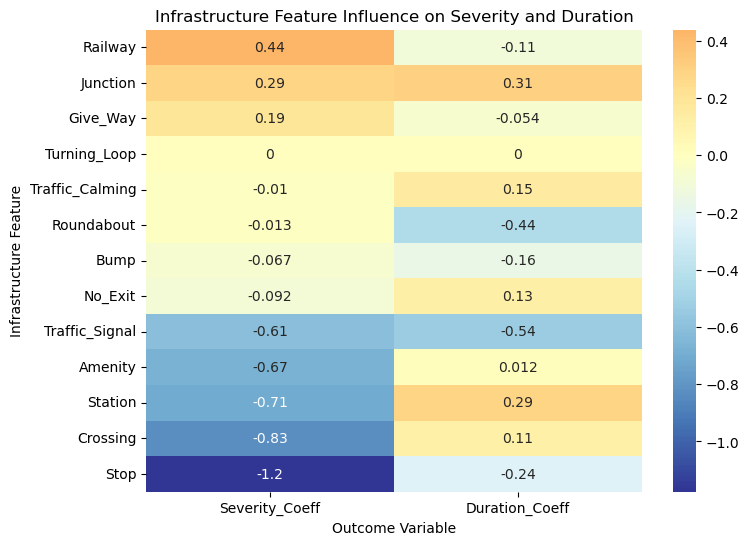


Composite Risk Cube (Weather × Infrastructure × Risk)


This view aggregates average risk scores across both weather and infrastructure features.
Each cell shows the mean composite risk (Severity × Duration × Precipitation),
normalized 0–100. Darker colors indicate higher operational strain — 
conditions and road types where accidents are longer, more severe, or harder to clear.



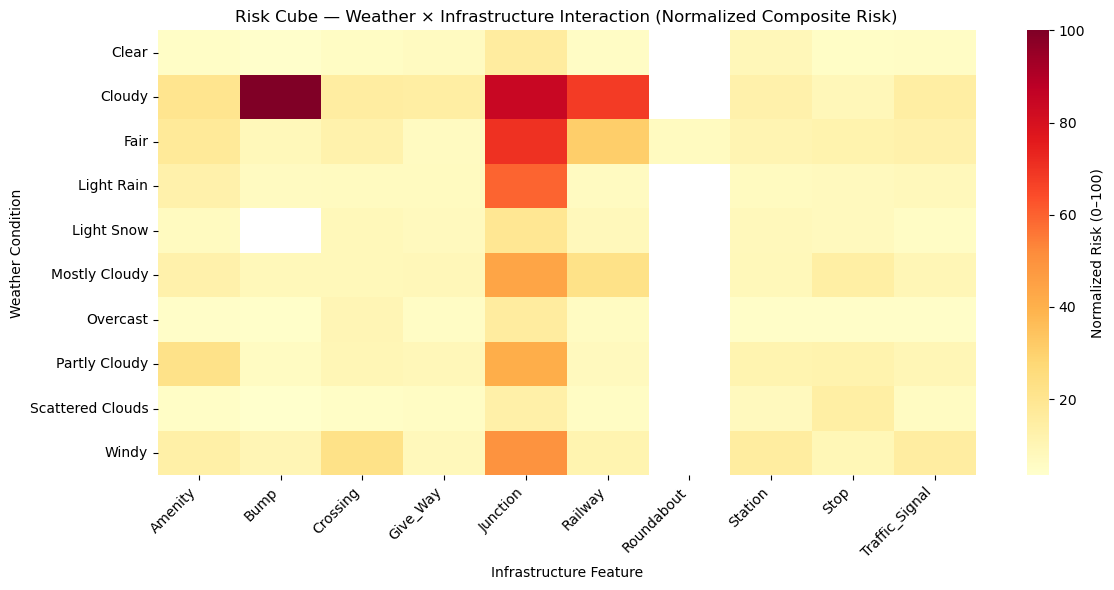

In [97]:
# =====================================================
# INFRASTRUCTURE FEATURE IMPORTANCE — SEVERITY & DURATION
# =====================================================
print_heading("Infrastructure Feature Importance (Quantitative View)")

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

# -----------------------------------------------------
# 1. Prepare a clean modeling subset
# -----------------------------------------------------
model_df = accidents_df.copy()

# Keep only infrastructure + outcome variables
infra_features = [
    'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
    'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
    'Traffic_Signal', 'Turning_Loop'
]

model_df = model_df[infra_features + ['Severity', 'Duration_hours']].dropna()

# Filter to realistic durations
model_df = model_df[model_df['Duration_hours'] <= 24]

X = model_df[infra_features].astype(int)
y_severity = model_df['Severity']
y_duration = model_df['Duration_hours']

# -----------------------------------------------------
# 2. Linear Regression for Duration
# -----------------------------------------------------
reg = LinearRegression()
reg.fit(X, y_duration)
duration_coef = pd.Series(reg.coef_, index=X.columns).sort_values()

# -----------------------------------------------------
# 3. Logistic Regression for High Severity (Severity ≥ 3)
# -----------------------------------------------------
model_df['Severe'] = (model_df['Severity'] >= 3).astype(int)
y_severe = model_df['Severe']

log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X, y_severe)
severity_coef = pd.Series(log_reg.coef_[0], index=X.columns).sort_values()

# -----------------------------------------------------
# 4. Combine into a Comparative Heatmap
# -----------------------------------------------------
importance_df = pd.DataFrame({
    "Severity_Coeff": severity_coef,
    "Duration_Coeff": duration_coef
}).sort_values("Severity_Coeff", ascending=False)

plt.figure(figsize=(8,6))
sns.heatmap(importance_df, annot=True, cmap="RdYlBu_r", center=0)
plt.title("Infrastructure Feature Influence on Severity and Duration")
plt.xlabel("Outcome Variable")
plt.ylabel("Infrastructure Feature")
plt.show()


# =====================================================
# COMPOSITE RISK CUBE — WEATHER × INFRASTRUCTURE × RISK
# =====================================================
print_heading("Composite Risk Cube (Weather × Infrastructure × Risk)")

print("""
This view aggregates average risk scores across both weather and infrastructure features.
Each cell shows the mean composite risk (Severity × Duration × Precipitation),
normalized 0–100. Darker colors indicate higher operational strain — 
conditions and road types where accidents are longer, more severe, or harder to clear.
""")

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Select top categories to keep the grid readable ---
weather_top = (
    accidents_df['Condition'].value_counts().head(10).index
    if 'Condition' in accidents_df.columns else
    accidents_df['Weather_Condition'].value_counts().head(10).index
)
infra_cols = [
    'Traffic_Signal', 'Junction', 'Crossing', 'Stop', 'Station', 
    'Amenity', 'Railway', 'Roundabout', 'Bump', 'Give_Way'
]

# --- Build long-form table of mean risk per condition + infra feature ---
melted_records = []
for w in weather_top:
    subset = accidents_df[
        (accidents_df['Condition'] == w) |
        (('Weather_Condition' in accidents_df.columns) and (accidents_df['Weather_Condition'] == w))
    ]
    for col in infra_cols:
        sub2 = subset[subset[col] == True]
        if len(sub2) > 50:  # skip sparse cells
            risk = (
                sub2['Severity'] * (sub2['Duration_hours'] + 0.1) * (sub2['Precipitation(in)'] + 1)
            ).mean()
            melted_records.append({'Weather': w, 'Infrastructure': col, 'Risk_Score': risk})

risk_cube = pd.DataFrame(melted_records)
risk_cube['Risk_Score_Norm'] = 100 * risk_cube['Risk_Score'] / risk_cube['Risk_Score'].max()

# --- Pivot to heatmap form ---
pivot = risk_cube.pivot(index='Weather', columns='Infrastructure', values='Risk_Score_Norm')

plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap="YlOrRd", annot=False, cbar_kws={'label': 'Normalized Risk (0–100)'})
plt.title("Risk Cube — Weather × Infrastructure Interaction (Normalized Composite Risk)")
plt.xlabel("Infrastructure Feature")
plt.ylabel("Weather Condition")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Infrastructure Takeaways

#### 1. Frequency and Exposure
* **Traffic signals and junctions** dominate in raw frequency, reflecting dense urban intersections where accidents are common but usually less severe.
* **Crossings and junctions** also show elevated **response times**, implying higher operational complexity (pedestrian involvement, multi-vehicle setups, or clearance bottlenecks).
* **Roundabouts and traffic calming** appear infrequently but correlate with **lower severity**, supporting their safety role.


#### 2. High-Risk Features (Severity × Duration)
* The composite **Infrastructure Risk Index** highlights **junctions, crossings, and give-way areas** as the top contributors to combined risk.
* These features serve as **decision points** — locations where human error, signal timing, or unclear priority drive both frequency and impact.
* **Highway incidents** show fewer occurrences but carry **longer average durations**, reflecting high-speed closures and complex cleanups.


#### 3. Feature Influence on Outcomes
* The regression-style heatmap shows that:
  * **Junctions** and **railways** correlate positively with both severity and duration — where traffic convergence or physical obstructions increase risk.
  * **Stops** and **signals** show **negative coefficients**, meaning they **reduce severity and duration** — confirming that enforced control points mitigate collision intensity.
* This duality captures how infrastructure can either **create or contain** risk depending on design and context.


#### 4. Composite Weather × Infrastructure Risk Cube
* Combining environmental and infrastructure dimensions reveals **compounding risks** — especially:
  * **Junctions and crossings under cloudy or rainy weather** show the **highest normalized composite risk**.
  * **Traffic-signal zones in rain or fog** demonstrate **moderate frequency but long clearance times**, amplifying total operational strain.
* This “risk cube” view clarifies how **environmental conditions magnify infrastructure weak points**, turning otherwise manageable intersections into high-risk scenarios.


#### Summary insight

Infrastructure acts as the stage where human behavior and environmental stress intersect.
**Signals and stops save lives** by containing chaos; **junctions and crossings create friction** where visibility or control falters.
Understanding how risk shifts across these features — and how weather amplifies it — is key to **prioritizing safety investments and rapid-response planning**.


---

## Analysis

Text here

## Evaluation

### Business Insight/Recommendation 1

### Business Insight/Recommendation 2

### Business Insight/Recommendation 3

### Tableau Dashboard link

## Conclusion and Next Steps
Text here